# Develop Spectral scheme with DC BC

In [2]:
from IPython.display import display, Markdown, Latex 

%run src/sps_test_suite.py

## The fully periodic spectral method

In [5]:

import numpy as np

import src.fd as fd
import src.schemes as schemes
import src.phase_schemes as ps
import src.wave_schemes as ws 
import src.config as config 
import src.animation as animation 

import matplotlib.pyplot as plt 
import scipy




import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

import src.cosmology as cosmology
import src.fd as fd


class FluxLimiters(Enum):
    #First-order linear
    DONORCELL   = lambda r: 0
    #Second-order linear
    BEAMWARMING = lambda r: r
    LAXWENDROFF = lambda r: 1
    #Second-order nonlinear
    MINMOD      = lambda r: np.maximum(0, np.minimum(1, r))
    SUPERBEE    = lambda r: np.maximum(0, np.maximum(np.minimum(2*r, 1), np.minimum(r, 2)))
    MC          = lambda r: np.maximum(0, np.minimum(np.minimum((1 + r) / 2, 2), 2 * r))
    #Smooth limiters
    VANLEER     = lambda r: (r + np.abs(r))/(1 + np.abs(r))
    VANALBADA   = lambda r: (r**2 + r)/(1+r**2)
    #Family of limiters parametrised by a,
    ALFA        = lambda r, a: np.maximum(0, np.minimum(2*r, np.minimum(a*r+1-a, 2)))
    #Third order limiter of ALFA family (SMART) for a = 0.75
    SMART       = lambda r: np.maximum(0, np.minimum(2*r, np.minimum(.75*r+.25, 4)))
    #CFL-dependent (s = dt/dx) limiters
    ULTRABEE    = lambda r, s: np.maximum(0, np.maximum(np.minimum(2*r/s, 1),np.minimum(r, 2/(1-s))))
    ULTRAALFA   = lambda r, s, a: np.maximum(0, np.minimum(2*r/s, np.minimum(a*(r-1) + 1, 2/(1-s))))

fluxLimiterDictionary = {
    "DONORCELL"   : FluxLimiters.DONORCELL,   
    "BEAMWARMING" : FluxLimiters.BEAMWARMING,
    "LAXWENDROFF" : FluxLimiters.LAXWENDROFF,
    "MINMOD"      : FluxLimiters.MINMOD,     
    "VANALBADA"   : FluxLimiters.VANALBADA,     
    "SUPERBEE"    : FluxLimiters.SUPERBEE, 
    "MC"          : FluxLimiters.MC, 
    "VANLEER"     : FluxLimiters.VANLEER,
    "SMART"       : FluxLimiters.SMART
}

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        # Store forward, backward and centered finite differences for convenience
        if self.stencilOrder % 2 == 0:
            self.left_shift = int(self.stencilOrder/2 - 1)
        else:
            self.left_shift = int((self.stencilOrder-1)/2)

        self.f1_stencil, self.f1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder, mode = fd.MODE_FORWARD)
        self.b1_stencil, self.b1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder, mode = fd.MODE_BACKWARD)
        self.c1_stencil, self.c1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder + self.stencilOrder % 2, mode = fd.MODE_CENTERED)
        self.c2_stencil, self.c2_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 2, accuracy = self.stencilOrder + self.stencilOrder % 2, mode = fd.MODE_CENTERED)

        self.limiter            = fluxLimiterDictionary[config["fluxLimiter"]]

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC = config["usePeriodicBC"]
        if self.usePeriodicBC:
            self.ghostBoundarySize = 1
        else:
            self.ghostBoundarySize = self.timeOrder * self.stencilOrder


        # Set up simulation grid
        N              = config["resolution"]
        boxWidth       = config["domainSize"]
        self.boxWidth  = boxWidth # physical box width
        self.innerN    = N
        self.dx        = boxWidth / (N + 1)


        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             =               - self.dx * self.ghostBoundarySize
        Lh             = self.boxWidth + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Create 1D grid
        xlin = np.linspace(Ll, Lh, num=N + 2)  # Note: x=0 & x=1 are the same point!
        xlin = xlin[1:-1]  # chop off periodic point)


        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)

        #Construct higher-dimensional grid 
        if self.dimension == 1:
            self.grid = [xlin]
            self.boundary = np.ix_(self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns)

        elif self.dimension == 2:
            self.grid = np.meshgrid(xlin, xlin)
            self.boundary = np.ix_(self.boundaryColumns, self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns, self.innerColumns)

        elif self.dimension == 3:
            self.grid = np.meshgrid(xlin, xlin, xlin, indexing='ij')
            self.boundary = np.ix_(self.boundaryColumns, self.boundaryColumns, self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns, self.innerColumns, self.innerColumns)

        else:
            raise ValueError("Dimension above 3 not supported")


        self.debug = config["debug"]
        self.generateIC = generateIC

        

    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")

    #Implement first to fourth order TVD-RK integrator by default
    #Can be overwritten in children classes to implement different time integration
    def step(self, dt):
        if not self.usePeriodicBC:
            self.setBoundaryConditions(self.fields)

        un = self.kick1(self.fields, dt)

        if self.outputTimestep:
            print(f"t = {self.t:.7f} dt = {dt:.7f} a = {self.getScaleFactor():.7f} ")

        if self.timeOrder == 1:
            un = un + 1 / 1 * self.getUpdatedFields(dt, un)

        elif self.timeOrder == 2:
            u1 = un + self.getUpdatedFields(dt, un)
            un = 1 / 2 * un + 1 / 2 * u1 + self.getUpdatedFields(1/2 * dt, u1)
            #u1 = un + self.getUpdatedFields(0.5 * dt, un)
            #un = un + self.getUpdatedFields(1.0 * dt, u1)

        elif self.timeOrder == 3:
            u1 = un + self.getUpdatedFields(dt, un)
            u2 = 3 / 4 * un + 1 / 4 * u1 +  self.getUpdatedFields(1/4 * dt, u1)
            un = 1 / 3 * un + 2 / 3 * u2 + self.getUpdatedFields(2/3 * dt, u2)

        elif self.timeOrder == 4:
            u1 = un + self.getUpdatedFields(0.39175222700392 * dt, un)
            u2 = (
                0.44437049406734 * un
                + 0.55562950593266 * u1
                + self.getUpdatedFields(0.36841059262959 * dt, u1)
            )
            u3 = (
                0.62010185138540 * un
                + 0.37989814861460 * u2
                + self.getUpdatedFields(0.25189177424738 * dt, u2)
            )
            u4 = (
                0.17807995410773 * un
                + 0.82192004589227 * u3
                + self.getUpdatedFields(0.54497475021237 * dt, u3)
            )
            un = (
                0.00683325884039 * un
                + 0.51723167208978 * u2
                + 0.12759831133288 * u3
                + self.getUpdatedFields(0.08460416338212 * dt, u3)
                + 0.34833675773694 * u4
                + self.getUpdatedFields(0.22600748319395 * dt, u4)
            )
        else:
            raise ValueError("Invalid time order")

        self.fields = self.kick2(un, dt)


        self.t += dt * self.getScaleFactor() ** 2

    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

        
#Define complex wave function psi as well as cosmology and gravity
class SchroedingerScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.hbar = config["hbar"]
        self.m    = config["m"]
        self.eta = self.hbar / self.m
        if self.debug:
            print(f"hbar/m is {self.eta}")

        self.psi = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential = np.zeros(self.psi.shape, dtype=np.float128)

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]


        if (self.G == 0) and self.useCosmology:
            raise ValueError(
                "Gravity required in expanding universe! Set config[Gravity] != 0."
            )

        if (self.G != 0) and not self.usePeriodicBC:
            raise ValueError(
                "Gravity only supported for periodic boundary conditions."
            )

        # Set up Fourier Space Variables for computing gravitational potential
        klin = np.pi / self.boxWidth * np.arange(1, self.totalN + 1)

        if self.dimension == 1:
            self.kx = np.fft.ifftshift(klin)
            self.momentumGrid = [self.kx]
            self.kSq = self.kx ** 2

        elif self.dimension == 2:
            kx, ky = np.meshgrid(klin, klin)
            self.kx, self.ky = np.fft.ifftshift(kx), np.fft.ifftshift(ky)
            self.momentumGrid = [self.kx, self.ky]
            self.kSq = self.kx ** 2 + self.ky ** 2

        elif self.dimension == 3:
            kx, ky, kz = np.meshgrid(klin, klin, klin, indexing='ij')
            self.kx, self.ky, self.kz = np.fft.ifftshift(kx), np.fft.ifftshift(ky), np.fft.ifftshift(kz)
            self.momentumGrid = [self.kx, self.ky, self.kz]
            self.kSq = self.kx ** 2 + self.ky ** 2 + self.kz ** 2

        else:
            raise ValueError("Dimension above 3 not supported")

        self.externalPotential = None 

        self.nThreads = config["nThreads"]
        if self.nThreads > 1:
            self.workers = self.nThreads # Tell scipy fft how many threads to use
        else:
            self.workers = None

        self.computePotential(np.abs(self.psi)**2)

    def setExternalPotentialFunction(self, potentialFunction):
        self.externalPotential = potentialFunction

    def computePotential(self, psisq):
        if np.isnan(psisq).any():
            print("psisq array in computePotential contained nan")
            self.t = self.tEnd 
            return 

        V = np.zeros(psisq.shape)

        if self.G != 0:
            V += 1/self.eta * fd.computePotential(
                psisq, self.m, self.G * self.getScaleFactor(), self.kSq, self.workers
            )

        if self.externalPotential is not None:
            V += 1/self.hbar * self.externalPotential(*self.grid, self.m)

        self.potential = V

        return V 

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return cosmology.getScaleFactor(self.t)
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

#Evolve wave function psi 
class WaveScheme(schemes.SchroedingerScheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

    def step(self, dt):

        if not self.usePeriodicBC:
            self.setBoundaryConditions(self.psi)

        # (1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        # drift
        self.drift(dt)

        #update potential
        self.potential = self.computePotential(np.abs(self.psi) ** 2)

        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi


        self.t += dt * self.getScaleFactor() ** 2

    def drift(self):
        raise NotImplementedError("Please Implement this method")

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi):
        f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]


class SpectralScheme(WaveScheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

    def drift(self, dt):
        # drift
        psihat = scipy.fft.fftn(self.psi, workers = self.workers)
        psihat = np.exp(dt * (-1.0j * self.eta * self.kSq / 2.0)) * psihat
        self.psi = scipy.fft.ifftn(psihat, workers = self.workers)


    def getName(self):
        return "spectral scheme"


# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 20
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

Finished in 10001 time steps


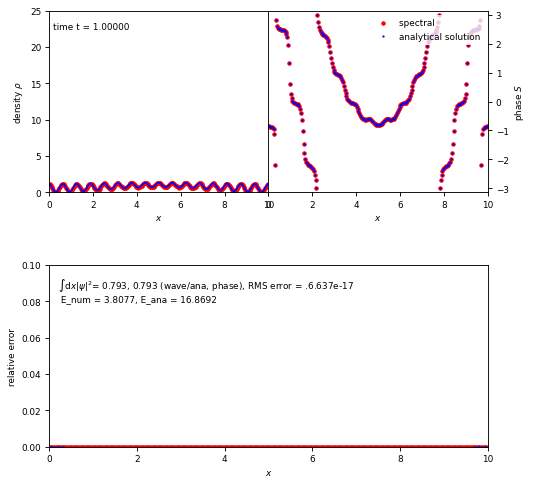

In [658]:
def extraConfig(c):
    c["nThreads"] = 2
    c["resolution"] = 256
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 1
    c["slowDown"] = 10
    c["tEnd"] = 1.0
    c["outputTimestep"] = True
    c["stencilOrder"] = 4
    c["timeOrder"] = 3
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 25]
    c["gravity"] = 0
    c["domainSize"] = 1
    c["plotDebug"] = True
    c["xlim"] = [0, 10]
    c["domainSize"] = 10
c = config.generateConfig()
extraConfig(c)
scheme = SpectralScheme(c, periodic1DGaussian)
scheme.run()


animation.drawFrame(solver = scheme, label = "spectral ", analyticalSolution = periodic1DGaussian, filename = "periodic_gs", waveSolver = None)

## The homogenised Spectral method

In [660]:


from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft,fft2,ifft2,ifft,irfft2,rfft2
import random as random
from mpl_toolkits.mplot3d import Axes3D



## Sine-Sine transform

### Sine Type 1

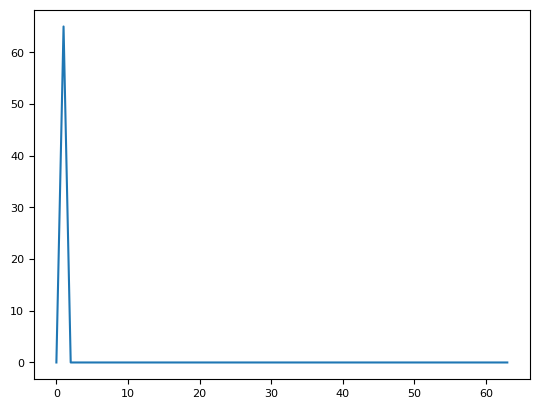

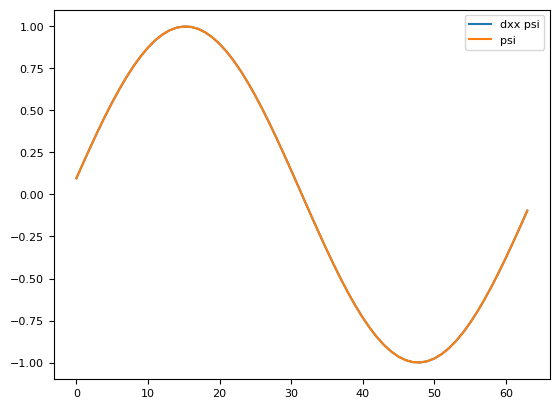

array([1.13659082e-14, 2.39808173e-14, 3.66928710e-14, 5.25135491e-14,
       6.35602682e-14, 5.44009282e-14, 4.08562073e-14, 6.71684930e-14,
       8.84847751e-14, 8.28226376e-14, 8.80406859e-14, 9.27036226e-14,
       9.83657600e-14, 1.17572618e-13, 1.37667655e-13, 1.18349774e-13,
       9.85878046e-14, 1.24233956e-13, 1.27342581e-13, 1.02806652e-13,
       9.61453139e-14, 9.08162434e-14, 7.51620988e-14, 7.40518757e-14,
       1.00031095e-13, 1.29896094e-13, 1.28230759e-13, 1.13853371e-13,
       1.18738352e-13, 7.60225216e-14, 2.61457522e-14, 1.32283073e-13,
       1.31998579e-13, 4.46864767e-14, 1.44995127e-13, 2.68118860e-14,
       8.32667268e-14, 5.31796829e-14, 3.41948692e-14, 1.33670852e-13,
       1.75526260e-13, 9.01501096e-14, 7.41628980e-14, 1.48547841e-13,
       1.68420833e-13, 1.04916076e-13, 6.49480469e-14, 9.70334924e-14,
       1.15019105e-13, 1.26676447e-13, 1.55542246e-13, 1.37667655e-13,
       6.23945340e-14, 7.53841434e-14, 1.41664458e-13, 1.96509475e-14,
      

In [85]:

N = 64

L = 1
x = np.linspace(0, L, N + 2)[1:-1] 
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(1, N+1)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 2 * np.pi 

psi = np.sin(q * x)
psihat = scipy.fft.dst(psi, type = 1)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2
hompsi = scipy.fft.idst(psihat, type = 1)
plt.plot(hompsi / q**2, label = "dxx psi")
plt.plot(psi, label = "psi")
plt.legend()
plt.show()
np.abs(psi - hompsi / q**2)

### Sine Type 2

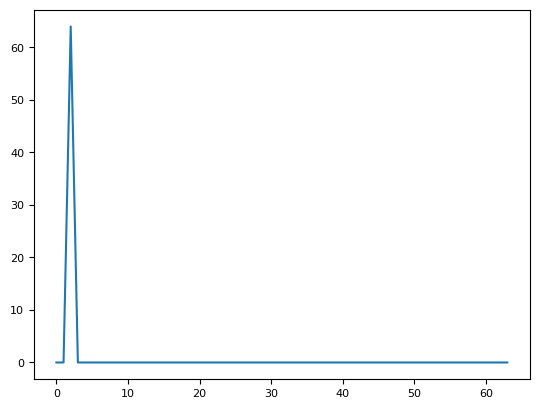

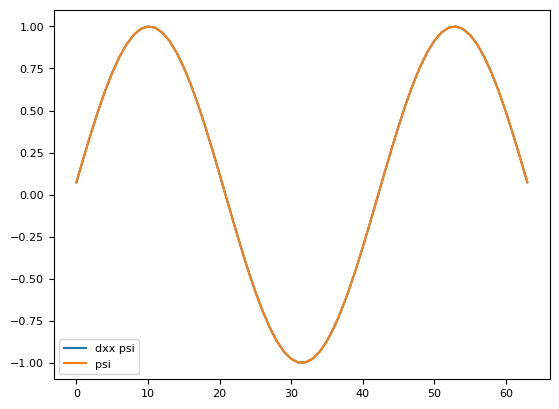

array([4.16611190e-14, 4.18276525e-14, 3.73034936e-14, 3.15858451e-14,
       4.05231404e-14, 2.93098879e-14, 1.24344979e-14, 2.83106871e-14,
       1.09912079e-14, 9.65894031e-15, 1.69864123e-14, 5.44009282e-15,
       8.88178420e-16, 1.36557432e-14, 8.43769499e-15, 2.26485497e-14,
       1.67643677e-14, 4.88498131e-15, 2.64788191e-14, 4.34097203e-14,
       4.04676292e-14, 1.31422651e-14, 1.80411242e-15, 4.18554080e-14,
       4.90718577e-14, 8.88178420e-16, 3.44169138e-15, 4.55191440e-14,
       3.26405569e-14, 6.66133815e-16, 2.06501483e-14, 2.03170814e-14,
       1.44328993e-15, 1.55431223e-15, 3.33066907e-15, 2.96429548e-14,
       6.08402217e-14, 5.56221735e-14, 6.45039577e-14, 9.25370891e-14,
       9.46465128e-14, 7.71327446e-14, 8.41618442e-14, 9.67836922e-14,
       4.09117185e-14, 3.48610030e-14, 6.87228052e-14, 6.85007606e-14,
       4.90718577e-14, 5.35127498e-14, 6.07291994e-14, 3.69704267e-14,
       4.44089210e-15, 1.29896094e-14, 8.21565038e-15, 3.48610030e-14,
      

In [151]:

N = 64

L = 1
dx = L/(N)
x = np.linspace(0+dx/2, L - dx/2, N)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(1, N+1)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 3 * np.pi 

psi = np.sin(q * x)
psihat = scipy.fft.dst(psi, type = 2)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2
hompsi = scipy.fft.idst(psihat, type = 2)
plt.plot(hompsi / q**2, label = "dxx psi")
plt.plot(psi, label = "psi")
plt.legend()
plt.show()
np.abs(psi - hompsi / q**2)

[0.00612607 0.01814279 0.0294623  0.03964958 0.04831315 0.05512008
 0.05980877 0.06219905 0.06219905 0.05980877 0.05512008 0.04831315
 0.03964958 0.0294623  0.01814279 0.00612607]


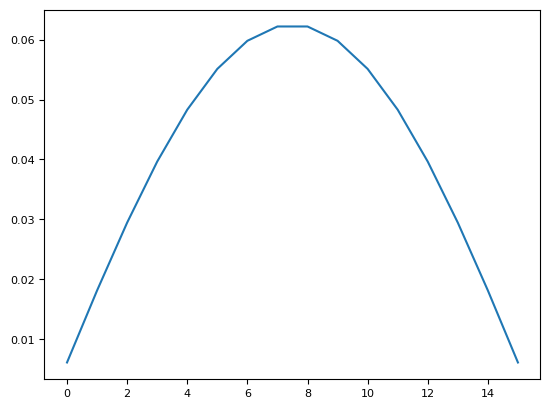

In [252]:
N = 16

y = np.zeros(N) 
y[0] = 1
hompsi = scipy.fft.idst(y, type = 2 )
plt.plot(hompsi)
print(hompsi)

In [166]:
x = np.linspace(0+0.125, 1-0.125, 4)
y = np.cos(2 * np.pi * x )
y /= y[0]
y *= hompsi[0]
y

array([ 0.35355339, -0.35355339, -0.35355339,  0.35355339])

## Cosine-Cosine transform

### Type 1

[ 6.59194921e-16  1.38273134e-14 -1.39784805e-14 -4.89750305e-15
 -4.28867607e-15  4.88791260e-15  1.23578199e-14 -1.61730508e-14
  1.59608865e-14  3.10590089e-15 -2.08653923e-14  1.41168409e-14
 -8.95998352e-15  6.97216184e-16 -6.21878628e-15  3.19744231e-14
  3.10000000e+01 -2.82571081e-14  2.31240066e-14 -7.56846176e-15
  1.95506723e-14 -1.83948694e-14  6.94161748e-15  1.00460879e-14
 -1.84103964e-14  7.54292785e-15 -7.38591441e-15  2.90089729e-15
 -4.53939266e-15  9.14901039e-15  2.05063336e-14 -4.75383621e-14]


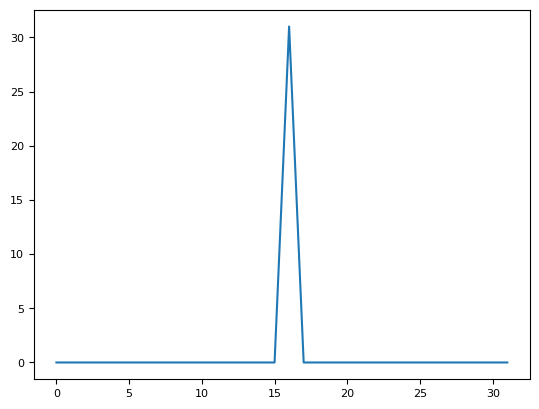

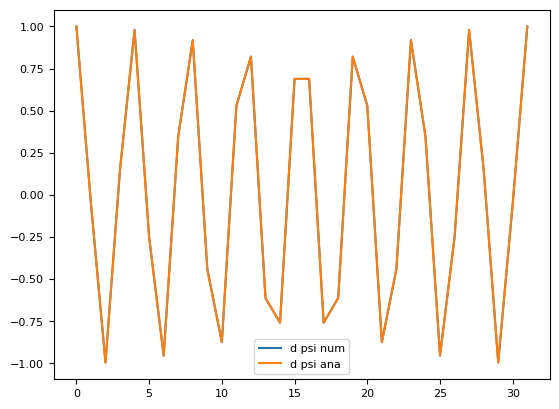

array([0.00000000e+00, 2.42861287e-16, 0.00000000e+00, 5.55111512e-17,
       3.33066907e-16, 0.00000000e+00, 5.55111512e-16, 3.33066907e-16,
       1.66533454e-15, 3.88578059e-16, 2.10942375e-15, 1.22124533e-15,
       2.99760217e-15, 1.66533454e-15, 2.55351296e-15, 1.44328993e-15,
       2.99760217e-15, 3.66373598e-15, 2.99760217e-15, 4.99600361e-15,
       2.88657986e-15, 1.88737914e-15, 3.21964677e-15, 1.55431223e-15,
       3.71924713e-15, 7.10542736e-15, 3.71924713e-15, 6.10622664e-15,
       2.05391260e-15, 1.66533454e-15, 1.31838984e-15, 3.33066907e-15])

In [123]:

N = 32

L = 4
x = np.linspace(0, L, N) 
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(0, N)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 4 * np.pi 

psi  = np.cos(q * x)
dpsi = np.cos(q * x)
psihat = scipy.fft.dct(psi, type = 1)
print(psihat)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2 
hompsi = scipy.fft.idct(psihat, type = 1)
plt.plot(hompsi / q**2, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(dpsi - hompsi / q**2)

### Type 2

[ 2.48689958e-14 -2.00211606e-14  8.17646730e-15  5.71840377e-15
 -8.55931823e-15  3.94107786e-15 -2.96725893e-15  5.52270620e-16
 -4.30195295e-15  4.54703299e-15 -4.13662678e-15  7.33467590e-15
 -5.15942375e-15  1.24324088e-14 -3.09199956e-15  1.10540864e-14
  3.20000000e+01 -3.44011792e-14  2.03287825e-14  3.47272152e-16
 -1.20825571e-15  6.84527420e-16  6.46782616e-15 -7.60491580e-15
  1.10214492e-15  2.69796529e-15 -2.61977867e-15 -2.90468632e-15
  4.72360912e-15 -1.85689819e-15 -2.38016946e-15  3.64106497e-15]


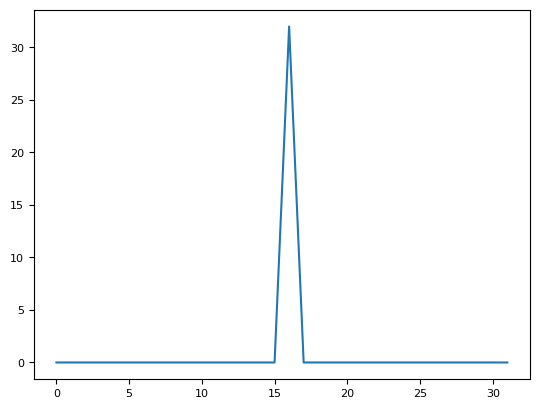

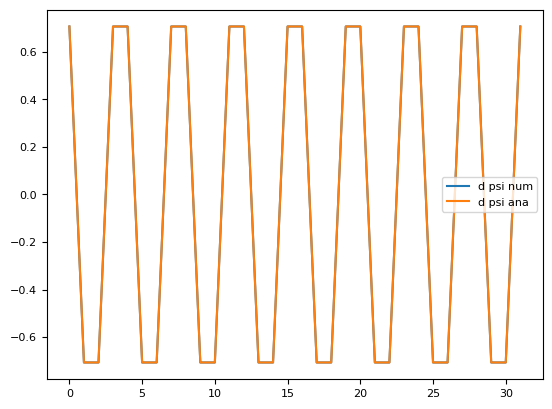

array([2.22044605e-16, 1.11022302e-16, 1.11022302e-16, 1.11022302e-16,
       4.44089210e-16, 2.22044605e-16, 2.22044605e-16, 2.22044605e-16,
       1.11022302e-16, 2.22044605e-16, 1.11022302e-16, 1.11022302e-16,
       0.00000000e+00, 1.11022302e-16, 1.11022302e-16, 0.00000000e+00,
       1.11022302e-16, 1.11022302e-16, 6.66133815e-16, 2.22044605e-15,
       6.66133815e-16, 1.55431223e-15, 8.88178420e-16, 1.44328993e-15,
       1.33226763e-15, 1.11022302e-15, 1.11022302e-15, 1.44328993e-15,
       1.55431223e-15, 1.11022302e-15, 1.44328993e-15, 2.22044605e-16])

In [181]:

N = 32

L = 4

dx = L/N 
x = np.linspace(0+dx/2, L-dx/2, N) 
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / L * np.arange(0, N)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 4 * np.pi 

psi  = np.cos(q * x)
dpsi = np.cos(q * x)
psihat = scipy.fft.dct(psi, type = 2)
print(psihat)
plt.plot(psihat)
plt.show()
psihat = psihat * klin**2 
hompsi = scipy.fft.idct(psihat, type = 2)
plt.plot(hompsi / q**2, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(dpsi - hompsi / q**2)

## Sine-Cosine Transform

[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.0625 1.1875
 1.3125 1.4375 1.5625 1.6875 1.8125 1.9375]
[ 0.38268343  0.92387953  0.92387953  0.38268343 -0.38268343 -0.92387953
 -0.92387953 -0.38268343  0.38268343  0.92387953  0.92387953  0.38268343
 -0.38268343 -0.92387953 -0.92387953 -0.38268343]


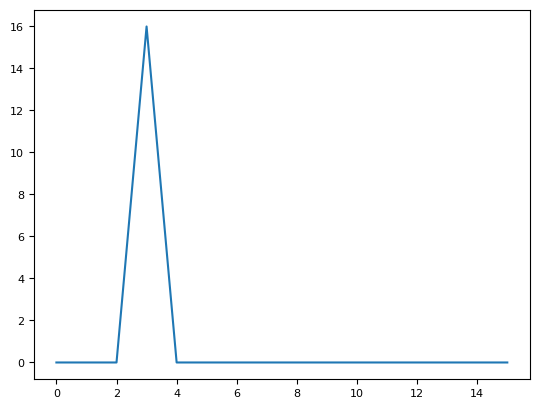

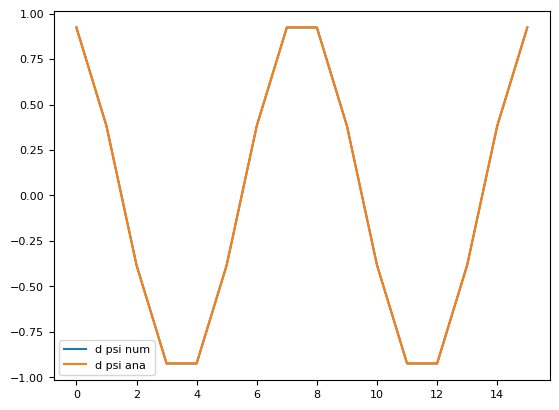

array([1.11022302e-16, 4.44089210e-16, 3.33066907e-16, 3.33066907e-16,
       1.11022302e-16, 1.49880108e-15, 1.88737914e-15, 3.33066907e-16,
       6.66133815e-16, 2.05391260e-15, 1.94289029e-15, 5.55111512e-16,
       5.55111512e-16, 2.22044605e-15, 2.44249065e-15, 1.33226763e-15])

In [257]:

N = 16

L = 2
dx = L/N
x = np.linspace(0+dx/2, L-dx/2, N)
print(x)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / (L) * np.arange(0, N)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 2 * np.pi 

psi  = np.sin(q * x)
dpsi = np.cos(q * x)
print(psi)
psihat = scipy.fft.dst(psi, type = 2)
plt.plot(psihat)
plt.show()
psihat = np.roll(psihat, 1)
psihat[0] = 0
psihat = psihat * klin
#plt.plot(psihat)
hompsi = scipy.fft.idct(psihat, type = 2)
plt.plot(hompsi / q, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(hompsi/ q- dpsi)

## Cosine-Sine Transform

[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125
 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]
[ 0.99518473  0.95694034  0.88192126  0.77301045  0.63439328  0.47139674
  0.29028468  0.09801714 -0.09801714 -0.29028468 -0.47139674 -0.63439328
 -0.77301045 -0.88192126 -0.95694034 -0.99518473]


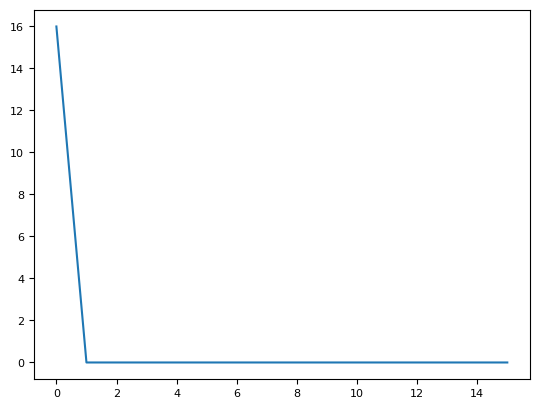

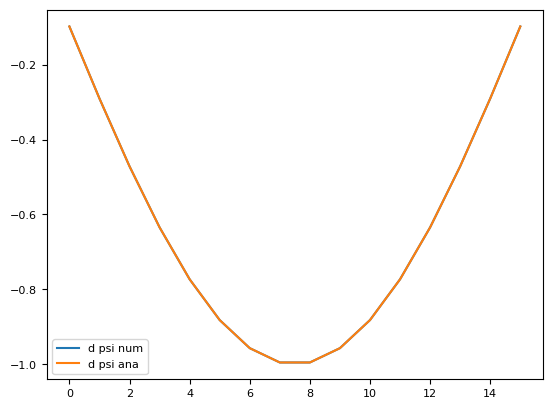

array([1.79023463e-15, 1.11022302e-15, 1.27675648e-15, 9.99200722e-16,
       2.22044605e-16, 6.66133815e-16, 1.11022302e-16, 4.44089210e-16,
       5.55111512e-16, 1.77635684e-15, 2.44249065e-15, 1.77635684e-15,
       3.10862447e-15, 3.77475828e-15, 3.83026943e-15, 4.91273688e-15])

In [256]:

N = 16

L = 1
dx = L/N
x = np.linspace(0+dx/2, L-dx/2, N)
print(x)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
klin = np.pi / (L) * np.arange(1, N+1)

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 1 * np.pi 

psi  = np.cos(q * x)
dpsi = -np.sin(q * x)
print(psi)
psihat = scipy.fft.dct(psi, type = 2)
psihat = np.roll(psihat,-1)
plt.plot(psihat)
plt.show()
#psihat[-1] = 0
psihat = psihat * klin
#plt.plot(psihat)
hompsi = scipy.fft.idst(-psihat, type = 2)
plt.plot(hompsi / q, label = "d psi num")
plt.plot(dpsi, label = "d psi ana")
plt.legend()
plt.show()
np.abs(hompsi/ q- dpsi)


## Sine-Cosine-Sine Transform

[0.03125 0.09375 0.15625 0.21875 0.28125 0.34375 0.40625 0.46875 0.53125
 0.59375 0.65625 0.71875 0.78125 0.84375 0.90625 0.96875]


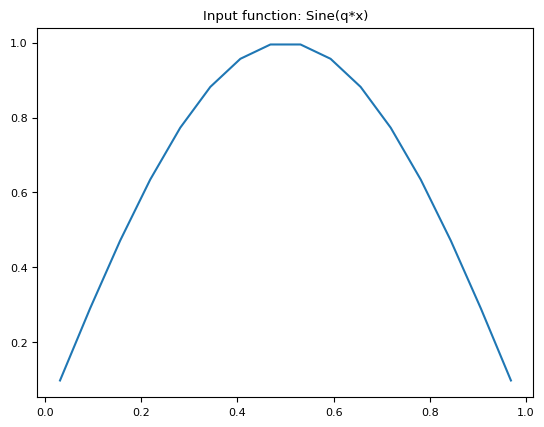

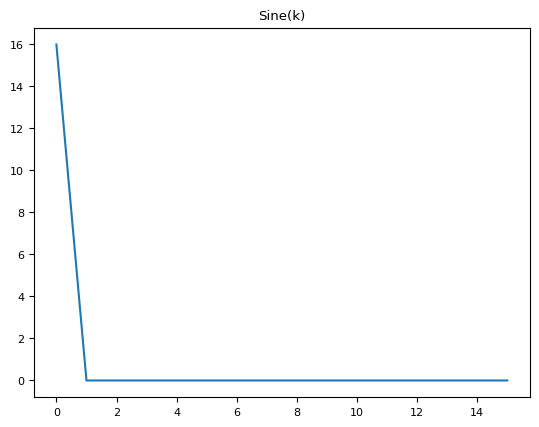

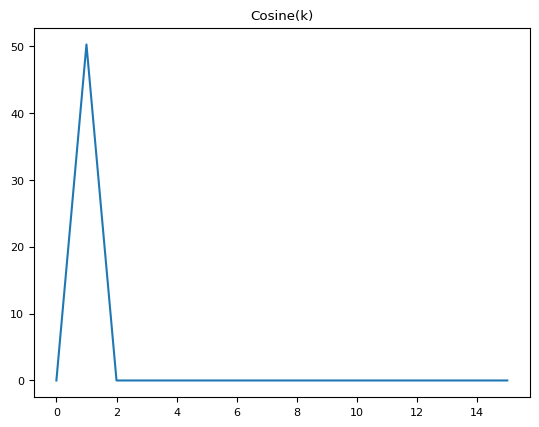

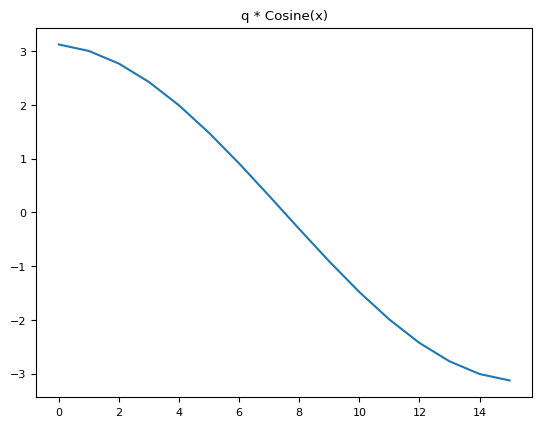

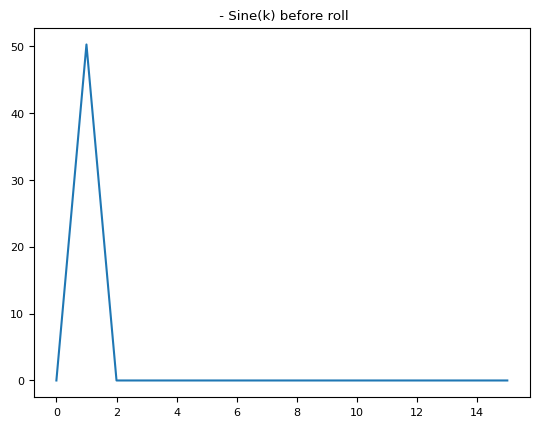

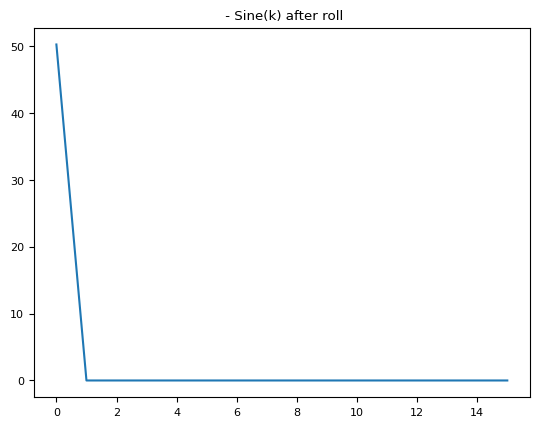

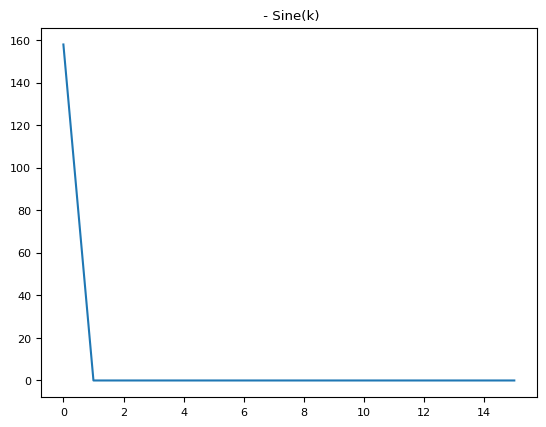

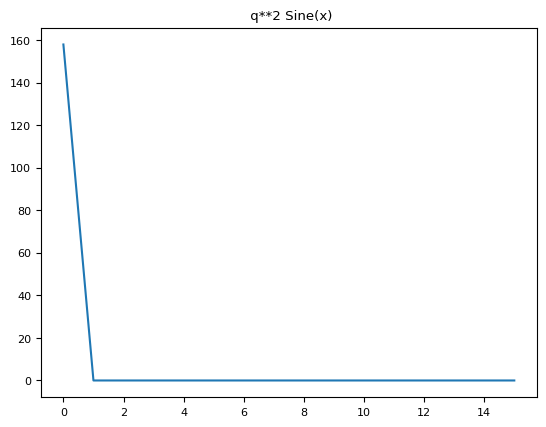

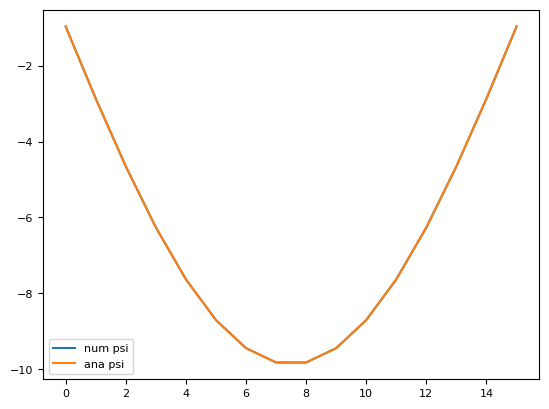

array([2.15161222e-13, 2.58015831e-13, 2.22044605e-13, 2.41584530e-13,
       3.09086090e-13, 3.05533376e-13, 2.96651592e-13, 2.14939178e-13,
       4.61852778e-14, 8.34887715e-14, 1.77635684e-13, 2.81552559e-13,
       3.25961480e-13, 3.60600438e-13, 4.09894341e-13, 4.64073224e-13])

In [277]:

N = 16

L = 1
dx = L/N
x = np.linspace(0+dx/2, L-dx/2, N)
print(x)
dx = x[1] -x[0]
# Set up Fourier Space Variables for computing gravitational potential
#kx = 2 * np.pi / ( 2* ( L - 1) + 1)  * np.arange(-N/ 2, N / 2)
#klin = np.fft.ifftshift(kx)
k_sin = np.pi / (L) * np.arange(1, N+1)
k_cos = np.pi / (L) * np.arange(0, N  )

#klin = np.pi / L * np.arange(1, N+1)
#klin = 1 / ( 2 * (klin - 4) + 1)
#klin = 1 / 1 * np.arange(-N/ 2, N / 2)
q = 1 * np.pi 

hompsi  = np.sin(q * x)
plt.title("Input function: Sine(q*x)")
plt.plot(x, hompsi)
plt.show()

psihat = scipy.fft.dst(hompsi, type = 2)
plt.title("Sine(k)")
plt.plot(psihat)
plt.show()
psihat = np.roll(psihat, 1)
psihat[0] = 0
psihat = psihat * k_cos
plt.title("Cosine(k)")
plt.plot(psihat)
plt.show()
hompsi = scipy.fft.idct(psihat, type = 2)

plt.title("q * Cosine(x)")
plt.plot(hompsi)
plt.show()
psihat = scipy.fft.dct(hompsi, type = 2)

plt.title(" - Sine(k) before roll")
plt.plot(psihat)
plt.show()

psihat = np.roll(psihat,-1)

plt.title(" - Sine(k) after roll")
plt.plot(psihat)
plt.show()
psihat[-1] = 0
psihat = psihat * k_sin

plt.title(" - Sine(k)")
plt.plot(psihat)
plt.show()

hompsi = scipy.fft.idst(-psihat, type = 2)


plt.title(" q**2 Sine(x)")
plt.plot(psihat)
plt.show()
plt.plot(hompsi, label = "num psi")
plt.plot(- q**2 * np.sin(q * x), label = "ana psi")
plt.legend()
plt.show()

np.abs(- q**2 * np.sin(q * x) - hompsi)


In [282]:


def get_x(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_k_sin(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin

def get_k_cos(L, N):
    k_cos = np.pi / (L) * np.arange(0, N  )
    return k_cos

def sin_derivative(psi, k_cos):
    psihat = scipy.fft.dst(psi, type = 2)
    psihat = np.roll(psihat, 1)
    psihat[0] = 0
    psihat = psihat * k_cos
    psi = scipy.fft.idct(psihat, type = 2)
    return psi


def cos_derivative(psi, k_sin):
    psihat = scipy.fft.dct(psi, type = 2)
    psihat = np.roll(psihat,-1)
    psihat[-1] = 0
    psihat = psihat * k_sin
    psi = scipy.fft.idst(-psihat, type = 2)
    return psi 



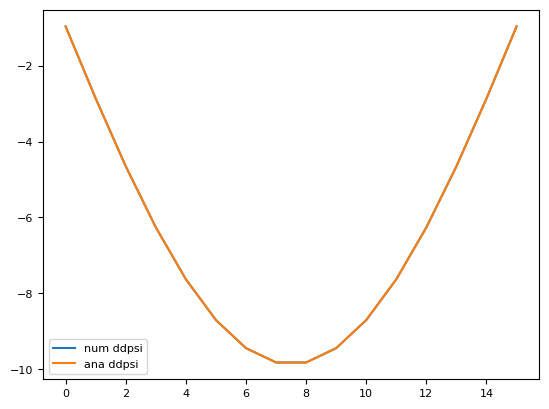

array([2.15161222e-13, 2.58015831e-13, 2.22044605e-13, 2.41584530e-13,
       3.09086090e-13, 3.05533376e-13, 2.96651592e-13, 2.14939178e-13,
       4.61852778e-14, 8.34887715e-14, 1.77635684e-13, 2.81552559e-13,
       3.25961480e-13, 3.60600438e-13, 4.09894341e-13, 4.64073224e-13])

In [283]:


N = 16
L = 1
q = 1 * np.pi 
xx   = get_x(L, N) 
k_cos = get_k_cos(L, N)
k_sin = get_k_sin(L, N)
psi  = np.sin(q * x)
dpsi = sin_derivative(psi, k_cos)
ddpsi = cos_derivative(dpsi, k_sin)



plt.plot(ddpsi, label = "num ddpsi")
plt.plot(- q**2 * np.sin(q * x), label = "ana ddpsi")
plt.legend()
plt.show()

np.abs(- q**2 * np.sin(q * x) - ddpsi)

In [4]:

import numpy as np

import src.fd as fd
import src.schemes as schemes
import src.phase_schemes as ps
import src.wave_schemes as ws 
import src.config as config 
import src.animation as animation 

import matplotlib.pyplot as plt 
import scipy


import numpy as np

import src.fd as fd
import src.schemes as schemes
import src.phase_schemes as ps
import src.wave_schemes as ws 
import src.config as config 
import src.animation as animation 

import matplotlib.pyplot as plt 
import scipy




import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

import src.cosmology as cosmology
import src.fd as fd


class FluxLimiters(Enum):
    #First-order linear
    DONORCELL   = lambda r: 0
    #Second-order linear
    BEAMWARMING = lambda r: r
    LAXWENDROFF = lambda r: 1
    #Second-order nonlinear
    MINMOD      = lambda r: np.maximum(0, np.minimum(1, r))
    SUPERBEE    = lambda r: np.maximum(0, np.maximum(np.minimum(2*r, 1), np.minimum(r, 2)))
    MC          = lambda r: np.maximum(0, np.minimum(np.minimum((1 + r) / 2, 2), 2 * r))
    #Smooth limiters
    VANLEER     = lambda r: (r + np.abs(r))/(1 + np.abs(r))
    VANALBADA   = lambda r: (r**2 + r)/(1+r**2)
    #Family of limiters parametrised by a,
    ALFA        = lambda r, a: np.maximum(0, np.minimum(2*r, np.minimum(a*r+1-a, 2)))
    #Third order limiter of ALFA family (SMART) for a = 0.75
    SMART       = lambda r: np.maximum(0, np.minimum(2*r, np.minimum(.75*r+.25, 4)))
    #CFL-dependent (s = dt/dx) limiters
    ULTRABEE    = lambda r, s: np.maximum(0, np.maximum(np.minimum(2*r/s, 1),np.minimum(r, 2/(1-s))))
    ULTRAALFA   = lambda r, s, a: np.maximum(0, np.minimum(2*r/s, np.minimum(a*(r-1) + 1, 2/(1-s))))

fluxLimiterDictionary = {
    "DONORCELL"   : FluxLimiters.DONORCELL,   
    "BEAMWARMING" : FluxLimiters.BEAMWARMING,
    "LAXWENDROFF" : FluxLimiters.LAXWENDROFF,
    "MINMOD"      : FluxLimiters.MINMOD,     
    "VANALBADA"   : FluxLimiters.VANALBADA,     
    "SUPERBEE"    : FluxLimiters.SUPERBEE, 
    "MC"          : FluxLimiters.MC, 
    "VANLEER"     : FluxLimiters.VANLEER,
    "SMART"       : FluxLimiters.SMART
}

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        # Store forward, backward and centered finite differences for convenience
        if self.stencilOrder % 2 == 0:
            self.left_shift = int(self.stencilOrder/2 - 1)
        else:
            self.left_shift = int((self.stencilOrder-1)/2)

        self.f1_stencil, self.f1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder, mode = fd.MODE_FORWARD)
        self.b1_stencil, self.b1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder, mode = fd.MODE_BACKWARD)
        self.c1_stencil, self.c1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder + self.stencilOrder % 2, mode = fd.MODE_CENTERED)
        self.c2_stencil, self.c2_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 2, accuracy = self.stencilOrder + self.stencilOrder % 2, mode = fd.MODE_CENTERED)

        self.limiter            = fluxLimiterDictionary[config["fluxLimiter"]]

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC = config["usePeriodicBC"]
        if self.usePeriodicBC:
            self.ghostBoundarySize = 0
        else:
            self.ghostBoundarySize = self.timeOrder * self.stencilOrder


        # Set up simulation grid
        N              = config["resolution"]
        boxWidth       = config["domainSize"]
        self.boxWidth  = boxWidth # physical box width
        self.innerN    = N
        #self.dx        = boxWidth / (N +1) # DST Type 1
        self.dx        = boxWidth / (N) # DST and DCT Type 2


        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             =               - self.dx * self.ghostBoundarySize
        Lh             = self.boxWidth + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Create 1D grid
        #xlin = np.linspace(Ll, Lh, num=N + 2)  # Note: x=0 & x=1 are the same point!
        print(f"Creating grid in [{Ll + dx/2}, {Lh - dx/2}] with {N} points")
        xlin = np.linspace(Ll + dx/2, Lh - dx/2, N)  # Note: x=0 & x=1 are the same point!
        #xlin = xlin[1:-1]  # chop off periodic point)

        print(xlin)

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 


        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)

        #Construct higher-dimensional grid 
        if self.dimension == 1:
            self.grid = [xlin]
            self.boundary = np.ix_(self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns)

        elif self.dimension == 2:
            self.grid = np.meshgrid(xlin, xlin)
            self.boundary = np.ix_(self.boundaryColumns, self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns, self.innerColumns)

        elif self.dimension == 3:
            self.grid = np.meshgrid(xlin, xlin, xlin, indexing='ij')
            self.boundary = np.ix_(self.boundaryColumns, self.boundaryColumns, self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns, self.innerColumns, self.innerColumns)

        else:
            raise ValueError("Dimension above 3 not supported")



        self.debug = config["debug"]
        self.generateIC = generateIC

        

    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")

    #Implement first to fourth order TVD-RK integrator by default
    #Can be overwritten in children classes to implement different time integration
    def step(self, dt):
        if not self.usePeriodicBC:
            self.setBoundaryConditions(self.fields)

        un = self.kick1(self.fields, dt)

        if self.outputTimestep:
            print(f"t = {self.t:.7f} dt = {dt:.7f} a = {self.getScaleFactor():.7f} ")

        if self.timeOrder == 1:
            un = un + 1 / 1 * self.getUpdatedFields(dt, un)

        elif self.timeOrder == 2:
            u1 = un + self.getUpdatedFields(dt, un)
            un = 1 / 2 * un + 1 / 2 * u1 + self.getUpdatedFields(1/2 * dt, u1)
            #u1 = un + self.getUpdatedFields(0.5 * dt, un)
            #un = un + self.getUpdatedFields(1.0 * dt, u1)

        elif self.timeOrder == 3:
            u1 = un + self.getUpdatedFields(dt, un)
            u2 = 3 / 4 * un + 1 / 4 * u1 +  self.getUpdatedFields(1/4 * dt, u1)
            un = 1 / 3 * un + 2 / 3 * u2 + self.getUpdatedFields(2/3 * dt, u2)

        elif self.timeOrder == 4:
            u1 = un + self.getUpdatedFields(0.39175222700392 * dt, un)
            u2 = (
                0.44437049406734 * un
                + 0.55562950593266 * u1
                + self.getUpdatedFields(0.36841059262959 * dt, u1)
            )
            u3 = (
                0.62010185138540 * un
                + 0.37989814861460 * u2
                + self.getUpdatedFields(0.25189177424738 * dt, u2)
            )
            u4 = (
                0.17807995410773 * un
                + 0.82192004589227 * u3
                + self.getUpdatedFields(0.54497475021237 * dt, u3)
            )
            un = (
                0.00683325884039 * un
                + 0.51723167208978 * u2
                + 0.12759831133288 * u3
                + self.getUpdatedFields(0.08460416338212 * dt, u3)
                + 0.34833675773694 * u4
                + self.getUpdatedFields(0.22600748319395 * dt, u4)
            )
        else:
            raise ValueError("Invalid time order")

        self.fields = self.kick2(un, dt)


        self.t += dt * self.getScaleFactor() ** 2

    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

        
#Define complex wave function psi as well as cosmology and gravity
class SchroedingerScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.hbar = config["hbar"]
        self.m    = config["m"]
        self.eta = self.hbar / self.m
        if self.debug:
            print(f"hbar/m is {self.eta}")

        self.psi = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential = np.zeros(self.psi.shape, dtype=np.float128)

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]


        if (self.G == 0) and self.useCosmology:
            raise ValueError(
                "Gravity required in expanding universe! Set config[Gravity] != 0."
            )

        if (self.G != 0) and not self.usePeriodicBC:
            raise ValueError(
                "Gravity only supported for periodic boundary conditions."
            )



        # Set up Fourier Space Variables for computing gravitational potential
        klin = np.pi / self.boxWidth * np.arange(1, self.totalN + 1)

        if self.dimension == 1:
            #self.kx = np.fft.ifftshift(klin)
            self.kx = klin
            self.momentumGrid = [self.kx]
            self.kSq = self.kx ** 2

        elif self.dimension == 2:
            kx, ky = np.meshgrid(klin, klin)
            self.kx, self.ky = np.fft.ifftshift(kx), np.fft.ifftshift(ky)
            self.momentumGrid = [self.kx, self.ky]
            self.kSq = self.kx ** 2 + self.ky ** 2

        elif self.dimension == 3:
            kx, ky, kz = np.meshgrid(klin, klin, klin, indexing='ij')
            self.kx, self.ky, self.kz = np.fft.ifftshift(kx), np.fft.ifftshift(ky), np.fft.ifftshift(kz)
            self.momentumGrid = [self.kx, self.ky, self.kz]
            self.kSq = self.kx ** 2 + self.ky ** 2 + self.kz ** 2

        else:
            raise ValueError("Dimension above 3 not supported")
        
        self.externalPotential = None 

        self.nThreads = config["nThreads"]
        if self.nThreads > 1:
            self.workers = self.nThreads # Tell scipy fft how many threads to use
        else:
            self.workers = None

        self.computePotential(np.abs(self.psi)**2)

    def setExternalPotentialFunction(self, potentialFunction):
        self.externalPotential = potentialFunction

    def computePotential(self, psisq):
        if np.isnan(psisq).any():
            print("psisq array in computePotential contained nan")
            self.t = self.tEnd 
            return 

        V = np.zeros(psisq.shape)

        if self.G != 0:
            V += 1/self.eta * fd.computePotential(
                psisq, self.m, self.G * self.getScaleFactor(), self.kSq, self.workers
            )

        if self.externalPotential is not None:
            V += 1/self.hbar * self.externalPotential(*self.grid, self.m)

        self.potential = V

        return V 

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return cosmology.getScaleFactor(self.t)
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)


#Evolve wave function psi 
class WaveScheme(SchroedingerScheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

    def step(self, dt):
        self.setBoundaryConditions(self.psi)

        # (1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        # drift
        self.drift(dt)

        #update potential
        self.potential = self.computePotential(np.abs(self.psi) ** 2)

        #(1/2) kick
        self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi


        self.t += dt * self.getScaleFactor() ** 2

    def drift(self):
        raise NotImplementedError("Please Implement this method")

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi):
        f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]

        self.psi0 = self.generateIC(self.Ll, self.dx, self.t, self.m, self.hbar)
        self.psi1 = self.generateIC(self.Lh, self.dx, self.t, self.m, self.hbar)


class HomogeneousSpectralScheme(WaveScheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        

    def drift(self, dt):

        xx   = self.grid[0]


        # construct smooth shift function B(x) with B(0) = psi(0) and B(-1) = psi(-1)
        B = (self.psi0 + (self.psi1 - self.psi0)/(self.Lh - self.Ll) * (xx - self.Ll))
        hompsi = (self.psi - B)

        # drift
        psihat = scipy.fft.dst(hompsi, type = 2, workers = self.workers)
        psihat = np.exp(dt * (-1.0j * self.eta * self.kx**2 / 2.0)) * psihat
        hompsi = scipy.fft.idst(psihat, type = 2, workers = self.workers)
        self.psi = hompsi + B


    def getName(self):
        return "hom. spectral scheme"


# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/10, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 20
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 



def planeWave(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/10, eps=0, L=10, N=100):
    psi = eps + 0j
    return np.exp(1j * x * 2*np.pi)

Creating grid in [0.0625, 9.9375] with 64 points
[0.0625     0.21924603 0.37599206 0.5327381  0.68948413 0.84623016
 1.00297619 1.15972222 1.31646825 1.47321429 1.62996032 1.78670635
 1.94345238 2.10019841 2.25694444 2.41369048 2.57043651 2.72718254
 2.88392857 3.0406746  3.19742063 3.35416667 3.5109127  3.66765873
 3.82440476 3.98115079 4.13789683 4.29464286 4.45138889 4.60813492
 4.76488095 4.92162698 5.07837302 5.23511905 5.39186508 5.54861111
 5.70535714 5.86210317 6.01884921 6.17559524 6.33234127 6.4890873
 6.64583333 6.80257937 6.9593254  7.11607143 7.27281746 7.42956349
 7.58630952 7.74305556 7.89980159 8.05654762 8.21329365 8.37003968
 8.52678571 8.68353175 8.84027778 8.99702381 9.15376984 9.31051587
 9.4672619  9.62400794 9.78075397 9.9375    ]
Finished in 4001 time steps
[array([0.0625    , 0.21924603, 0.37599206, 0.5327381 , 0.68948413,
       0.84623016, 1.00297619, 1.15972222, 1.31646825, 1.47321429,
       1.62996032, 1.78670635, 1.94345238, 2.10019841, 2.25694444,
      

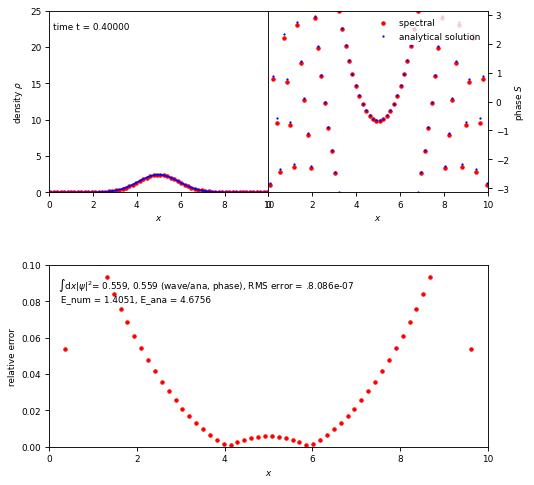

In [234]:
def extraConfig(c):
    c["nThreads"] = 4
    c["resolution"] = 64
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 1
    c["slowDown"] = 10
    c["tEnd"] = 0.4
    c["outputTimestep"] = True
    c["stencilOrder"] = 4
    c["timeOrder"] = 3
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 25]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 10]
    c["domainSize"] = 10
    c["usePeriodicBC"] = True
c = config.generateConfig()
extraConfig(c)
scheme = HomogeneousSpectralScheme(c, periodic1DGaussian)
scheme.run()
print(scheme.grid)

animation.drawFrame(solver = scheme, label = "spectral ", analyticalSolution = periodic1DGaussian, filename = "periodic_gs", waveSolver = None)

## The PML spectral method

In [73]:
def get_x(L, N):
    dx = L/N
    xx = np.linspace(0+dx/2, L-dx/2, N)
    return xx

def get_k_sin(L, N):
    k_sin = np.pi / (L) * np.arange(1, N+1)
    return k_sin

def get_k_cos(L, N):
    k_cos = np.pi / (L) * np.arange(0, N  )
    return k_cos

def sin_derivative(psi, k_cos):
    psihat = scipy.fft.dst(psi, type = 2)
    psihat = np.roll(psihat, 1)
    psihat[0] = 0
    psihat = psihat * k_cos
    psi = scipy.fft.idct(psihat, type = 2)
    return psi


def cos_derivative(psi, k_sin):
    psihat = scipy.fft.dct(psi, type = 2)
    psihat = np.roll(psihat,-1)
    psihat[-1] = 0
    psihat = psihat * k_sin
    psi = scipy.fft.idst(-psihat, type = 2)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        # Store forward, backward and centered finite differences for convenience
        if self.stencilOrder % 2 == 0:
            self.left_shift = int(self.stencilOrder/2 - 1)
        else:
            self.left_shift = int((self.stencilOrder-1)/2)

        self.f1_stencil, self.f1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder, mode = fd.MODE_FORWARD)
        self.b1_stencil, self.b1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder, mode = fd.MODE_BACKWARD)
        self.c1_stencil, self.c1_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 1, accuracy = self.stencilOrder + self.stencilOrder % 2, mode = fd.MODE_CENTERED)
        self.c2_stencil, self.c2_coeff  = fd.getFiniteDifferenceCoefficients(derivative_order = 2, accuracy = self.stencilOrder + self.stencilOrder % 2, mode = fd.MODE_CENTERED)

        self.limiter            = fluxLimiterDictionary[config["fluxLimiter"]]

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC = config["usePeriodicBC"]
        if self.usePeriodicBC:
            self.ghostBoundarySize = 6
        else:
            self.ghostBoundarySize = self.timeOrder * self.stencilOrder


        # Set up simulation grid
        N              = config["resolution"]
        boxWidth       = config["domainSize"]
        self.boxWidth  = boxWidth # physical box width
        self.innerN    = N
        #self.dx        = boxWidth / (N +1) # DST Type 1
        self.dx        = boxWidth / (N) # DST and DCT Type 2


        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             =               - self.dx * self.ghostBoundarySize
        Lh             = self.boxWidth + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Create 1D grid
        #xlin = np.linspace(Ll, Lh, num=N + 2)  # Note: x=0 & x=1 are the same point!
        #print(f"Creating grid in [{Ll + dx/2}, {Lh - dx/2}] with {N} points")
        xlin = get_x(self.PLMWidth, self.totalN) + Ll # Note: x=0 & x=1 are the same point!
        #xlin = xlin[1:-1]  # chop off periodic point)

        #print(xlin)

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 


        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)

        #Construct higher-dimensional grid 
        if self.dimension == 1:
            self.grid = [xlin]
            self.boundary = np.ix_(self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns)

        elif self.dimension == 2:
            self.grid = np.meshgrid(xlin, xlin)
            self.boundary = np.ix_(self.boundaryColumns, self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns, self.innerColumns)

        elif self.dimension == 3:
            self.grid = np.meshgrid(xlin, xlin, xlin, indexing='ij')
            self.boundary = np.ix_(self.boundaryColumns, self.boundaryColumns, self.boundaryColumns)
            self.inner    = np.ix_(self.innerColumns, self.innerColumns, self.innerColumns)

        else:
            raise ValueError("Dimension above 3 not supported")



        self.debug = config["debug"]
        self.generateIC = generateIC

        

    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")

    #Implement first to fourth order TVD-RK integrator by default
    #Can be overwritten in children classes to implement different time integration
    def step(self, dt):
        self.setBoundaryConditions(self.fields)

        un = self.kick1(self.fields, dt)

        if self.outputTimestep:
            print(f"t = {self.t:.7f} dt = {dt:.7f} a = {self.getScaleFactor():.7f} ")

        if self.timeOrder == 1:
            un = un + 1 / 1 * self.getUpdatedFields(dt, un)

        elif self.timeOrder == 2:
            u1 = un + self.getUpdatedFields(dt, un)
            un = 1 / 2 * un + 1 / 2 * u1 + self.getUpdatedFields(1/2 * dt, u1)
            #u1 = un + self.getUpdatedFields(0.5 * dt, un)
            #un = un + self.getUpdatedFields(1.0 * dt, u1)

        elif self.timeOrder == 3:
            u1 = un + self.getUpdatedFields(dt, un)
            u2 = 3 / 4 * un + 1 / 4 * u1 +  self.getUpdatedFields(1/4 * dt, u1)
            un = 1 / 3 * un + 2 / 3 * u2 + self.getUpdatedFields(2/3 * dt, u2)

        elif self.timeOrder == 4:
            u1 = un + self.getUpdatedFields(0.39175222700392 * dt, un)
            u2 = (
                0.44437049406734 * un
                + 0.55562950593266 * u1
                + self.getUpdatedFields(0.36841059262959 * dt, u1)
            )
            u3 = (
                0.62010185138540 * un
                + 0.37989814861460 * u2
                + self.getUpdatedFields(0.25189177424738 * dt, u2)
            )
            u4 = (
                0.17807995410773 * un
                + 0.82192004589227 * u3
                + self.getUpdatedFields(0.54497475021237 * dt, u3)
            )
            un = (
                0.00683325884039 * un
                + 0.51723167208978 * u2
                + 0.12759831133288 * u3
                + self.getUpdatedFields(0.08460416338212 * dt, u3)
                + 0.34833675773694 * u4
                + self.getUpdatedFields(0.22600748319395 * dt, u4)
            )
        else:
            raise ValueError("Invalid time order")

        self.fields = self.kick2(un, dt)


        self.t += dt * self.getScaleFactor() ** 2

    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

        
#Define complex wave function psi as well as cosmology and gravity
class SchroedingerScheme(Scheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)

        self.hbar = config["hbar"]
        self.m    = config["m"]
        self.eta = self.hbar / self.m
        if self.debug:
            print(f"hbar/m is {self.eta}")

        self.psi = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.potential = np.zeros(self.psi.shape, dtype=np.float128)

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]


        if (self.G == 0) and self.useCosmology:
            raise ValueError(
                "Gravity required in expanding universe! Set config[Gravity] != 0."
            )

        if (self.G != 0) and not self.usePeriodicBC:
            raise ValueError(
                "Gravity only supported for periodic boundary conditions."
            )



        # Set up Fourier Space Variables for computing gravitational potential
        klin = np.pi / self.boxWidth * np.arange(1, self.totalN + 1)

        if self.dimension == 1:
            #self.kx = np.fft.ifftshift(klin)
            self.kx = klin
            self.momentumGrid = [self.kx]
            self.kSq = self.kx ** 2

        elif self.dimension == 2:
            kx, ky = np.meshgrid(klin, klin)
            self.kx, self.ky = np.fft.ifftshift(kx), np.fft.ifftshift(ky)
            self.momentumGrid = [self.kx, self.ky]
            self.kSq = self.kx ** 2 + self.ky ** 2

        elif self.dimension == 3:
            kx, ky, kz = np.meshgrid(klin, klin, klin, indexing='ij')
            self.kx, self.ky, self.kz = np.fft.ifftshift(kx), np.fft.ifftshift(ky), np.fft.ifftshift(kz)
            self.momentumGrid = [self.kx, self.ky, self.kz]
            self.kSq = self.kx ** 2 + self.ky ** 2 + self.kz ** 2

        else:
            raise ValueError("Dimension above 3 not supported")
        
        self.externalPotential = None 

        self.nThreads = config["nThreads"]
        if self.nThreads > 1:
            self.workers = self.nThreads # Tell scipy fft how many threads to use
        else:
            self.workers = None

        self.computePotential(np.abs(self.psi)**2)

    def setExternalPotentialFunction(self, potentialFunction):
        self.externalPotential = potentialFunction

    def computePotential(self, psisq):
        if np.isnan(psisq).any():
            print("psisq array in computePotential contained nan")
            self.t = self.tEnd 
            return 

        V = np.zeros(psisq.shape)

        if self.G != 0:
            V += 1/self.eta * fd.computePotential(
                psisq, self.m, self.G * self.getScaleFactor(), self.kSq, self.workers
            )

        if self.externalPotential is not None:
            V += 1/self.hbar * self.externalPotential(*self.grid, self.m)

        self.potential = V

        return V 

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return cosmology.getScaleFactor(self.t)
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)


#Evolve wave function psi 
class WaveScheme(SchroedingerScheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.fields = self.psi

    def getUpdatedFields(self, dt, psi):
        #self.setBoundaryConditions(psi)

        # (1/2) kick
        #self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        # drift
        dpsi = self.drift(dt, psi)

        #update potential
        #self.potential = self.computePotential(np.abs(self.psi) ** 2)

        #(1/2) kick
        #self.psi = np.exp(-1.0j * dt / 2 * self.potential) * self.psi

        return dpsi

    def drift(self):
        raise NotImplementedError("Please Implement this method")

    def getDensity(self):
        self.psi = self.fields
        return np.abs(self.psi) ** 2

    def getPhase(self):
        self.psi = self.fields
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi):
        f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]

        self.psi0 = self.generateIC(self.Ll, self.dx, self.t, self.m, self.hbar)
        self.psi1 = self.generateIC(self.Lh, self.dx, self.t, self.m, self.hbar)

def S_func(x, L0_phys, L0_PLM, L1_phys, L1_PLM, sigma0, delta, gamma = np.pi/4):
    y = np.ones(x.shape, complex)


    y[x <= L0_phys] = 1 + np.exp(1j * gamma) * sigma_func(x[x <= L0_phys] - L0_PLM, sigma0, delta)
    y[x >= L1_phys] = 1 + np.exp(1j * gamma) * sigma_func(x[x >= L1_phys] - L1_PLM, sigma0, delta)
    return y

def sigma_func(x, sigma0, delta):
    return sigma0 / x**2# - sigma0 / delta**2




class PLMSpectralScheme(WaveScheme):
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        
            
        self.delta  = np.abs(self.Lh - self.boxWidth)
        self.sigma0 = config["sigma0"]
        print("absorber width", self.delta)

        self.S = S_func(x = self.grid[0], L0_phys = 0, L0_PLM = self.Ll, L1_phys = self.boxWidth, L1_PLM = self.Lh, sigma0 = self.sigma0, delta = self.delta)
        # Set up Fourier Space Variables for computing gravitational potential
        self.k_cos = get_k_cos(self.PLMWidth, self.totalN)
        self.k_sin = get_k_sin(self.PLMWidth, self.totalN)

    
    def drift(self, dt, psi):

        xx   = self.grid[0]

        if 0:
            q = 3 * np.pi 

            phi = np.sin(q * xx) 
            phi0 = np.sin(q * self.Ll) 
            phi1 = np.sin(q * self.Lh)


            B = (phi0 + (phi1 - phi0)/(self.Lh - self.Ll) * (xx - self.Ll))
            homphi = phi - B 

            plt.title("Phi")
            plt.plot(xx, phi, label="org")
            plt.plot(xx, homphi, label="hom")
            plt.legend()
            plt.show()


            dphi = sin_derivative(homphi, self.k_cos)
            ddphi = cos_derivative(dphi, self.k_sin) + B 
            plt.title(f"The sine experiment L1 - error: {np.mean(np.abs(-phi*q**2 - ddphi)[self.inner]):.2e}")
            plt.plot(xx, -phi*q**2, label="analytical")
            plt.plot(xx, ddphi, label="numerical")
            plt.legend()
            plt.show()

            dphi = sin_derivative(homphi, self.k_cos)
            dphi = dphi / self.S
            ddphi = cos_derivative(dphi, self.k_sin)
            ddphi = ddphi / self.S 
            ddphi += B 
            plt.title(f"The sine PLM experiment L1 - error: {np.mean(np.abs(-phi*q**2 - ddphi)[self.inner]):.2e}")
            plt.plot(xx[self.inner], (-phi*q**2)[self.inner], label="analytical")
            plt.plot(xx[self.inner], ddphi[self.inner], label="numerical")
            plt.legend()
            plt.show()

            errors = []
            sigmas = np.logspace(-6, 6, 100)
            for sigma0 in sigmas:
                myS = S(x = self.grid[0], L0_phys = 0, L0_PLM = self.Ll, L1_phys = self.boxWidth, L1_PLM = self.Lh, sigma0 = sigma0, delta = self.delta)

                dphi = sin_derivative(homphi, self.k_cos)
                dphi = dphi / myS
                ddphi = cos_derivative(dphi, self.k_sin)
                ddphi = ddphi / myS 
                ddphi += B 
                errors.append(np.mean(np.abs(-phi*q**2 - ddphi)[self.inner]))
            plt.title(f"Delta = {self.delta}")
            plt.loglog(sigmas, errors)
            plt.xlabel("sigma")
            plt.ylabel("L1 Error")
            plt.show()

        # construct smooth shift function B(x) with B(0) = psi(0) and B(-1) = psi(-1)
        B = (self.psi0 + (self.psi1 - self.psi0)/(self.Lh - self.Ll) * (xx - self.Ll))
        hompsi = (psi - B)
        
        # drift
        # forward sine transform since we enforce homogeneous DC BC 
        dpsi = sin_derivative(hompsi, self.k_cos)
        plt.title("dpsi before absorver")
        plt.plot(dpsi)
        plt.show()
        dpsi /= self.S
        plt.title("dpsi after absorver")
        plt.plot(dpsi)
        plt.show()
        ddpsi = cos_derivative(dpsi, self.k_sin) 
        plt.title("ddpsi before absorver")
        plt.plot(ddpsi)
        plt.show()
        ddpsi /= self.S
        plt.title("ddpsi after absorver")
        plt.plot(ddpsi)
        plt.show()
        return 1.0/2.0 * dt * 1.0j * self.eta * ddpsi

    def getName(self):
        return "PLM spectral scheme"

absorber width 0.0625


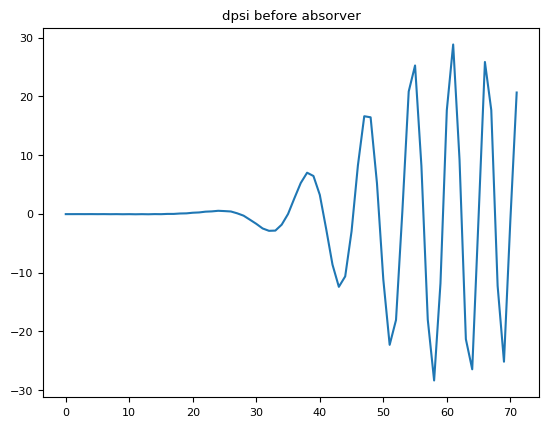

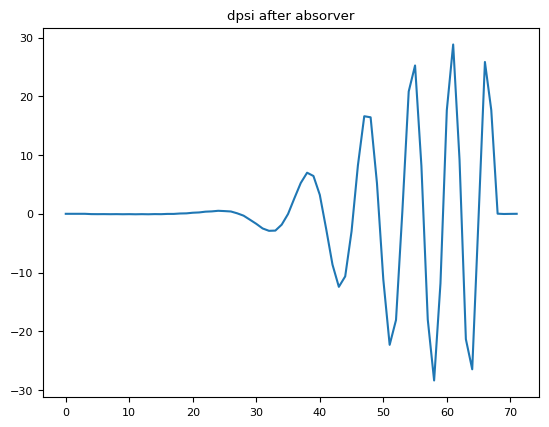

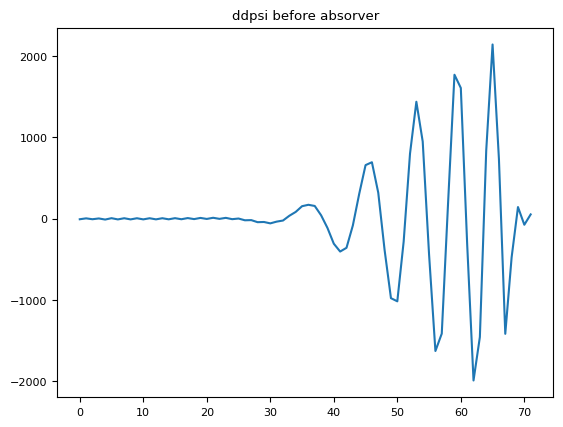

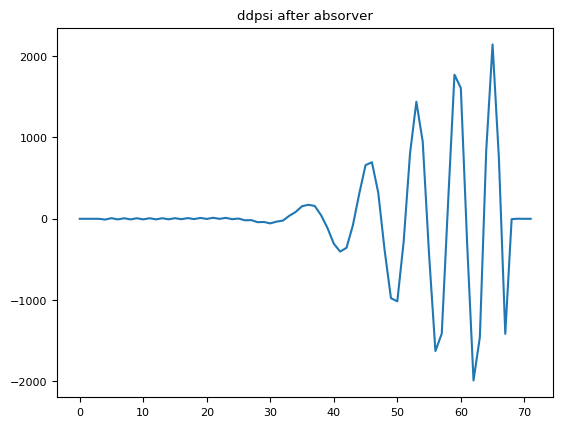

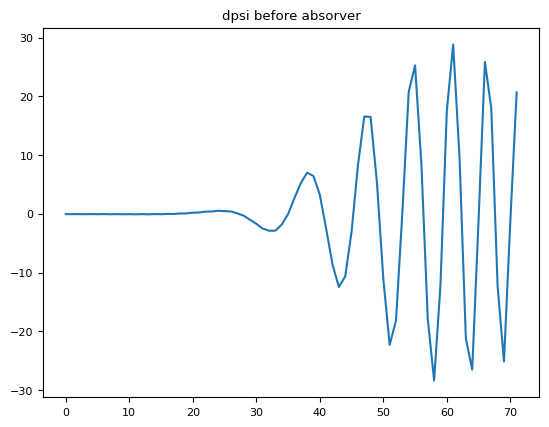

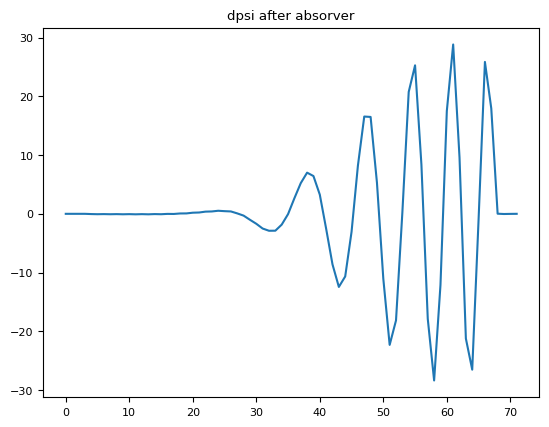

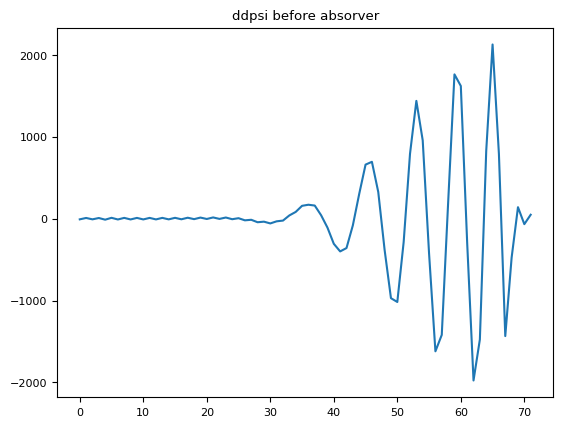

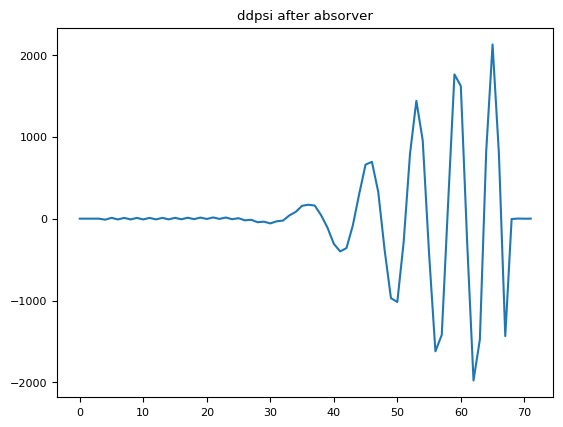

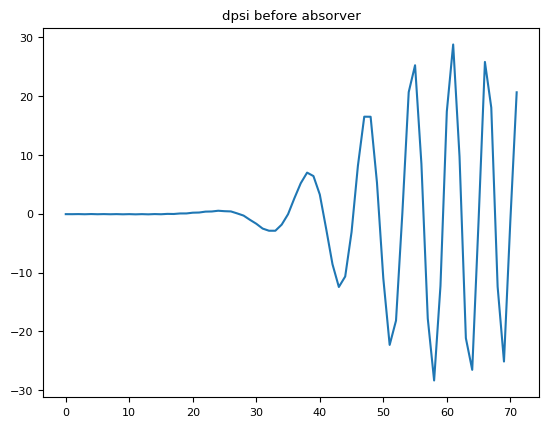

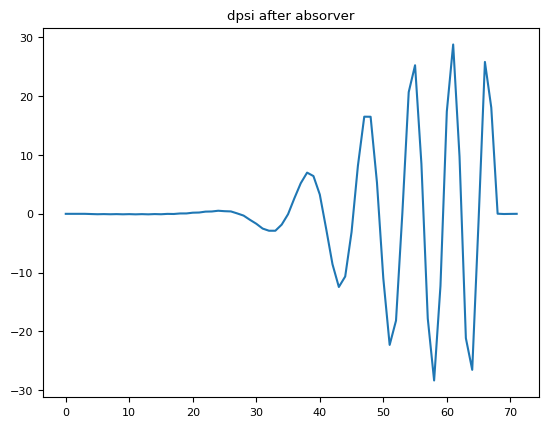

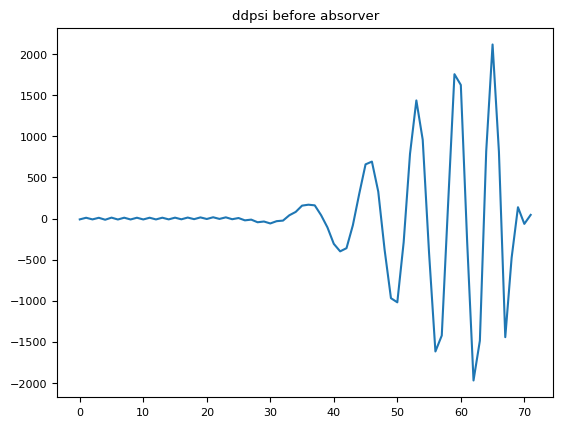

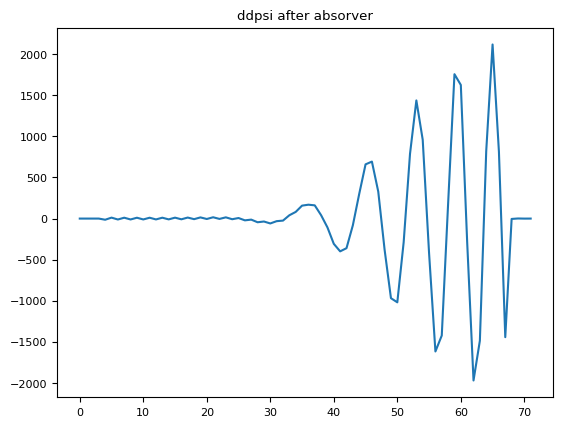

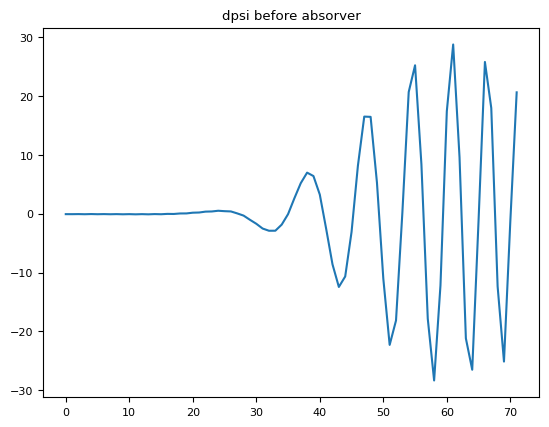

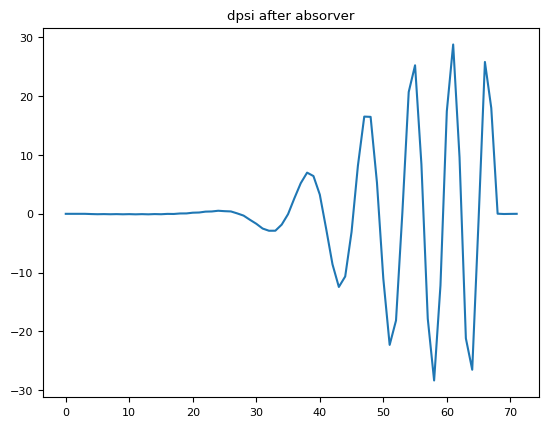

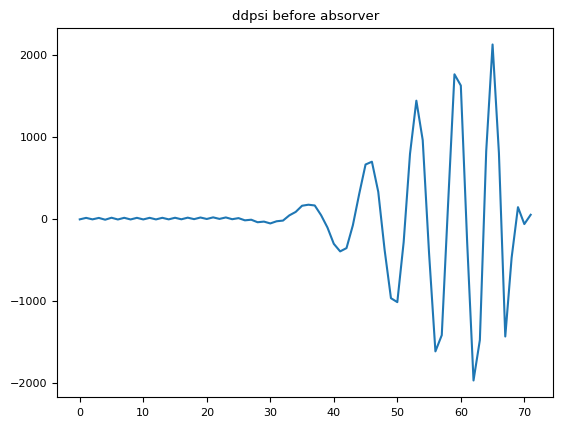

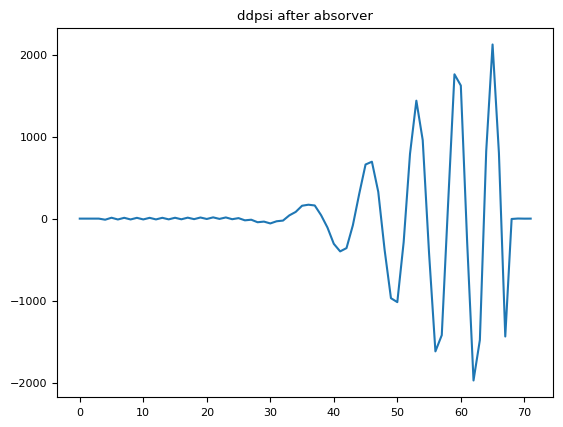

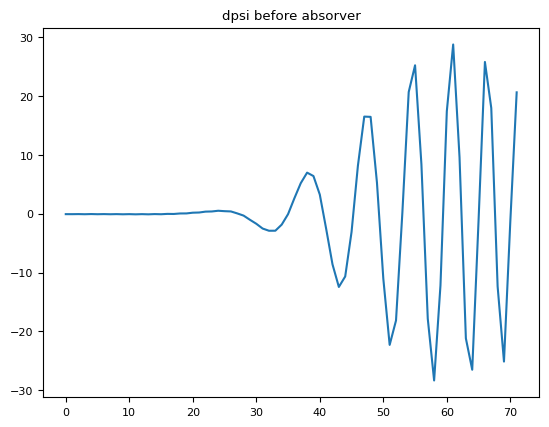

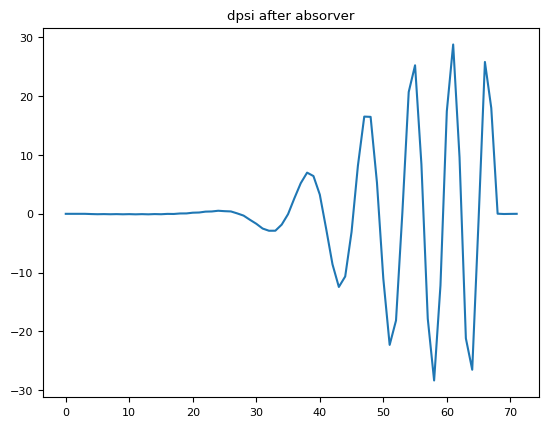

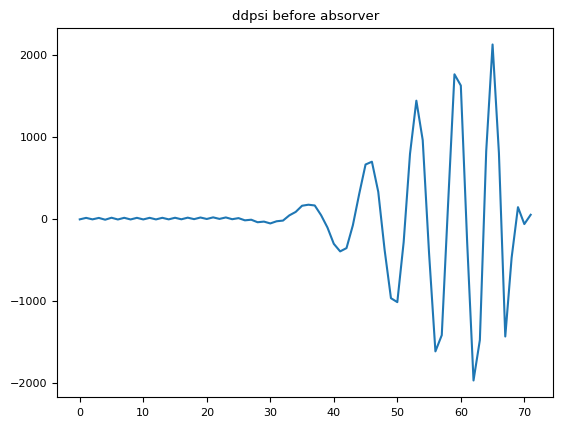

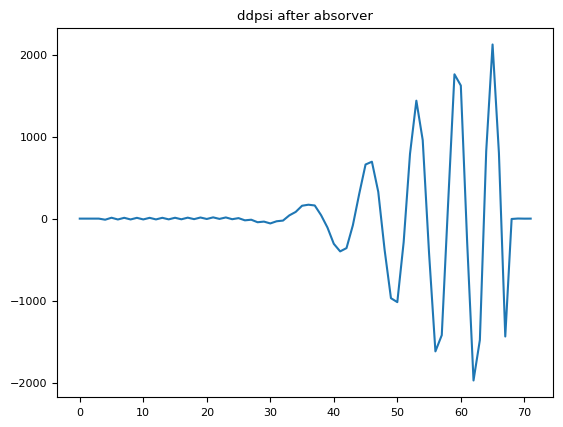

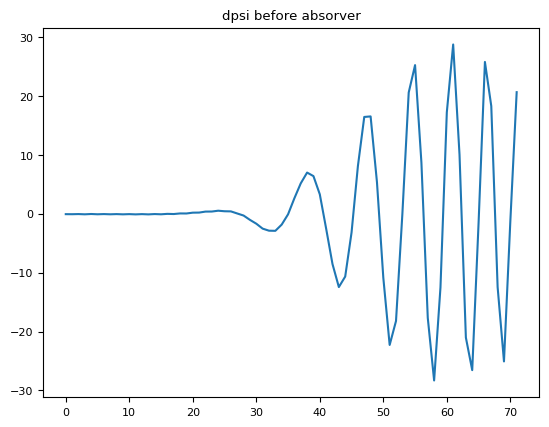

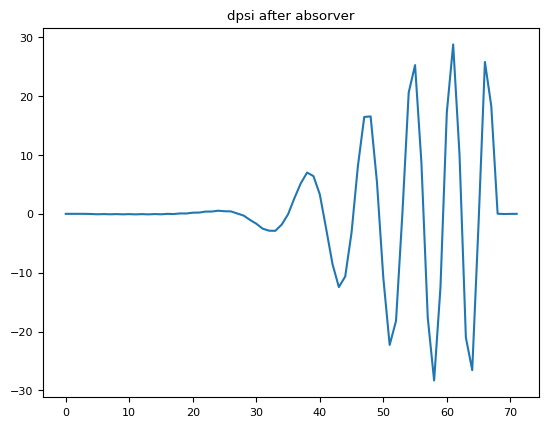

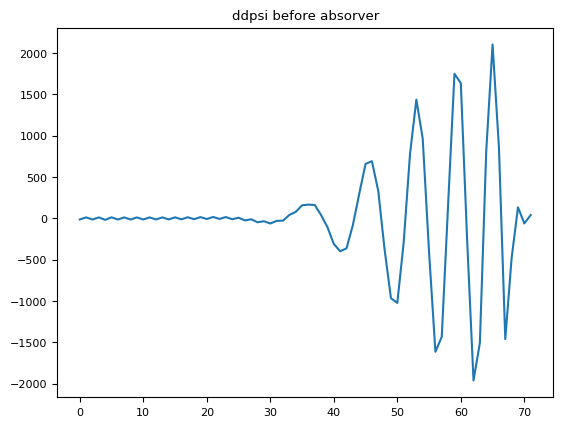

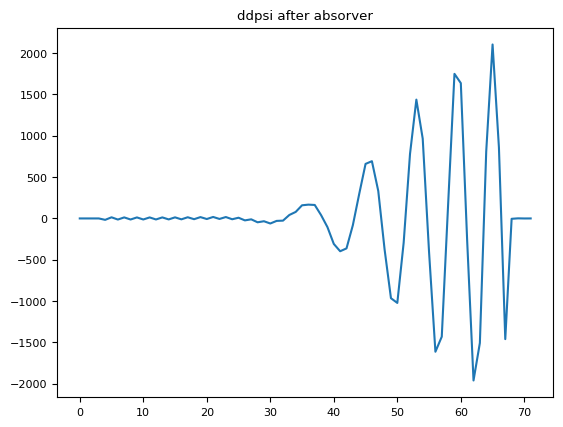

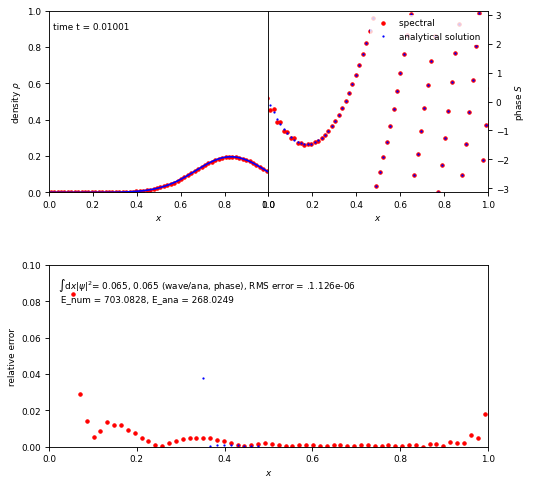

In [75]:

def planeWave(xx, dx, t, m = 1, hbar = 1,  k = 1):
    omega = hbar/(2*m) * k**2
    return np.exp(1j*(k*xx - omega * t))


def travellingWavePacket(x, dx, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.2):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi

def extraConfig(c):
    c["nThreads"] = 4
    c["resolution"] = 64
    #c["phaseYlim"] = [-100, 100]
    c["dpi"] = 80
    c["fps"] = 1
    c["slowDown"] = 10
    c["t0"] = 0.01
    c["tEnd"] = 0.012
    c["outputTimestep"] = False
    c["stencilOrder"] = 1
    c["timeOrder"] = 4
    c["C_parabolic"] = .4
    c["C_velocity"] = 1
    c["plotDensityLogarithm"] = False
    c["densityYlim"] = [0, 1]
    c["gravity"] = 0
    c["plotDebug"] = True
    c["xlim"] = [0, 1]
    c["domainSize"] = 1
    c["usePeriodicBC"] = False
    c["useAdaptiveTimestep"] = True 
    c["sigma0"] = 1
c = config.generateConfig()
extraConfig(c)
scheme = PLMSpectralScheme(c, travellingWavePacket)
scheme.step(1e-5)
#scheme.run(0.005)
#animation.drawFrame(solver = scheme, label = "spectral ", analyticalSolution = travellingWavePacket, filename = "periodic_gs", waveSolver = None)
#scheme.run(0.007)
#animation.drawFrame(solver = scheme, label = "spectral ", analyticalSolution = travellingWavePacket, filename = "periodic_gs", waveSolver = None)
#scheme.run(0.01)
animation.drawFrame(solver = scheme, label = "spectral ", analyticalSolution = travellingWavePacket, filename = "periodic_gs", waveSolver = None)



Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
Finished in 103 time steps
F

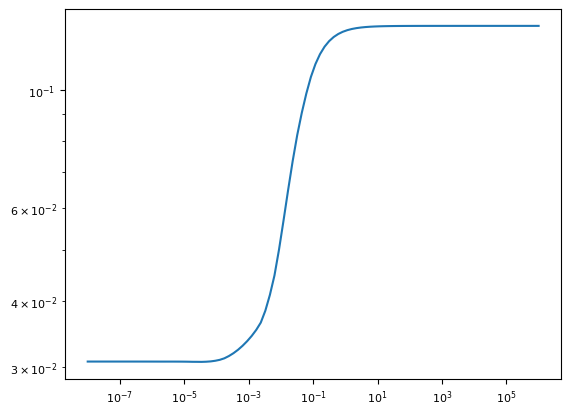

In [65]:
sigmas = np.logspace(-8, 6, 100)
errors = []
for sigma in sigmas:
    c["sigma0"] = sigma 
    c["timeOrder"] = 3
    c["stencilOrder"] = 4
    c["usePeriodicBC"] = False
    scheme = PLMSpectralScheme(c, travellingWavePacket)
    scheme.run(0.01)
    psi_ref     = scheme.generateIC(scheme.grid[0], scheme.dx, scheme.t, scheme.m, scheme.hbar)
    density_ref = np.abs(psi_ref) ** 2
    density     = scheme.getDensity()
    #plt.title(f"sigma = {sigma}")
    #plt.plot(density)
    #plt.plot(density_ref)
    #plt.show()

    rms_error = np.mean(np.abs(density - density_ref))/np.mean(np.abs(density_ref))
    errors.append(rms_error)

plt.loglog(sigmas, errors)

In [18]:

def S(x, L0_phys, L0_PLM, L1_phys, L1_PLM, sigma, gamma = np.pi/4):
    y = np.ones(x.shape, complex)


    y[x <= L0_phys] = 1 + np.exp(1j * gamma) * sigma(x[x <= L0_phys] - L0_PLM)
    y[x >= L1_phys] = 1 + np.exp(1j * gamma) * sigma(x[x >= L1_phys] - L1_PLM)
    return y
    
delta = 0.5
sigma0 = 5e-2 

def sigma(x):
    return sigma0 / x + 1-8)**2 - sigma0 / delta**2

x = np.linspace(-0.5, 1.5, 30) 
plt.plot(x, np.imag(S(x, 0, -0.5, 1, 1.5, sigma )))

SyntaxError: unmatched ')' (361258558.py, line 13)

In [148]:
import scipy
import src.cosmology as cosmology 


def normalise(psi):
    norm = np.mean(np.abs(psi)**2)
    return psi/np.sqrt(norm + (norm == 0) * 1e-12)

# Calculate the gradient by Richardson extrapolation (with periodic boundary condition)
def GRAD(field, axis, h, order):
    dim = list(field.shape)
    dim.insert(0, order)
    grad = np.zeros(tuple(dim))
    for o in range(order):
        interval = 2**(order-1-o)
        grad[o] = (np.roll(field, -interval, axis=axis) - np.roll(field, interval, axis=axis)) / (2*interval)
    for o in range(1,order):
        grad[o:] = (4.**o*grad[o:]-grad[o-1:-1]) / (4.**o-1.)
    return grad[-1]/h
    
# Physical Constant
phidm_mass = 2e-23 #eV
h_bar = 1.0545718e-34
eV_to_kg = 1.78266192162790e-36
Mpc_to_m = 3.0856776e22
#####################################################################################################################

def antisymmetricMode(x, y, dx, t, kSq, N, m, hbar, L, eps, a_c, H0):

    box_length = L
    factor = box_length*1000.
    h = dx
    k_factor = 2.*np.pi/N
    box_length *= Mpc_to_m/(H0/100.) # meter
    a = cosmology.getScaleFactor(t) 
    delta = a / a_c 
    delta_dot = 2 * a**(3/2) / a_c
    rho_bar = 1 
    kp = 1/L
    ka = 2 /L
    chi = x + eps / ( 2 * np.pi * ka ) * kp / ka * np.cos ( 2 * np.pi * ka * y )
    Cy = np.cos(2 * np.pi * ka * y) 
    Cx = np.cos(2 * np.pi * kp * chi) 
    Sy = np.sin(2 * np.pi * ka * y) 
    Sx = np.sin(2 * np.pi * kp * chi)
    vx = + delta_dot / (2 * np.pi * kp) * Sx
    vy = - delta_dot / (2 * np.pi * ka) * Sx * Sy * eps
    rho = rho_bar / ( 1 + delta * Cx - delta * eps * ( Sx * Cy - 2 * np.pi * kp * eps * Cx * Sy**2))

    # Calculate div(v)
    vx_x = GRAD(vx, axis = 0, h=dx ,order=3)
    vy_y = GRAD(vy, axis = 1, h=dx ,order=3)
    v_div = vx_x + vy_y
    v_div *= a*phidm_mass*eV_to_kg/h_bar
    
    # Do forward DFT
    v_div_k = scipy.fft.fftn(v_div)
    phi_fft  = np.real(scipy.fft.ifftn(v_div_k  / ( kSq  + (kSq==0))))
    # Rescale to correct unit
    phi_fft *= box_length/N**2
    phi_fft -= phi_fft.min()
  
    psi = np.sqrt(rho) * np.exp(1 * phi_fft)
    return normalise(psi), vx, vy, phi_fft



In [168]:
xx = np.linspace(0, 1, 101)

xx[1] - xx[0]

0.01

In [149]:
a0 = 0.01 
t0 = cosmology.getTime(a0)
L  = 10
N  = 512
x  = np.linspace(0, L, N)
dx = x[1] - x[0]
xx, yy = np.meshgrid(x, x) 
# Set up Fourier Space Variables for computing gravitational potential
klin = 2.0 * np.pi / L * np.arange(-N / 2, N / 2)

kx, ky = np.meshgrid(klin, klin)
kx, ky = np.fft.ifftshift(kx), np.fft.ifftshift(ky)
momentumGrid = [kx, ky]
kSq = kx ** 2 + ky ** 2

psi, vx, vy, phi = antisymmetricMode(xx, yy, dx, t0, kSq, m = 1e-23, hbar = h_bar, L = L, N = N, eps = 0.2, a_c = 0.13, H0 = 100)

Maximum level is 8 .
Box length is 10.0000 Mpc/h.
H0 is 67.3212 km/s/Mpc.
z_start is 100.00 .
0.0390625 0.00390625
0.07623762376237625 0.015171854187360233


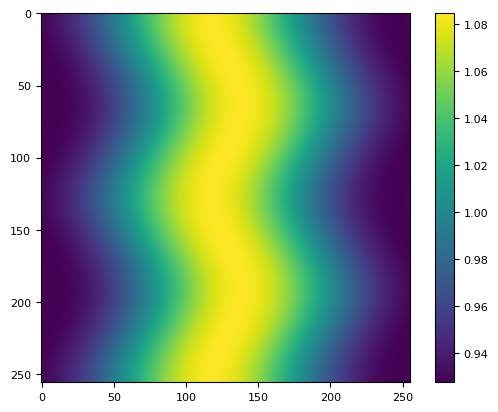

In [178]:
#!/usr/bin/env python3.7

############################################################################################
# This script is used for genertating the wave function needed for GAMER with ELBDM from   #
# MUSIC, included its real and imaginary parts. Be sure the requirements below are met:    # 
# (1) Input configuration file (ics_example.conf here) for MUSIC is under the same folder. #
# (2) Output generic hdf5 file (generated by the above input file)is under the same folder.#
# (3) Adjust the phidm_mass in physical constant if needed.                                #
#				                                                           #
# Use handle S/D to select output UM_IC as single/double precision and assign the hdf5 file#
# when running this script, e.g. ./make_umic_from_hdf5.py S(D) hdf5_filename               #
#											   #
# The code does the follwing things:							   #
# (1) Scan through the input file to collect parameters					   #
# (2) Calculate the density from over-density given by MUSIC				   #
# (3) Calculate the phase from velocity by solving the poisson quation in spcetrum way:    #
#          a*phidm_mass*(div(velocity))/h_bar = del(phase)                                 #
#     div is evaluated via Richardson extrapolation with an adjustable order		   #
# (4) Convert density and phase field to real and imaginary part of wave function          #
# (5) Output as binary file "UM_IC"							   #
#											   #
# Unit(s): MUCIS v.s. here								   #
# (1) density: back ground density ; back ground density				   #
# (2) velocity: box length*H_0	   ; m/s					  	   #
############################################################################################

import os, h5py, subprocess, re, sys
import numpy as np

# Calculate the gradient by Richardson extrapolation (with periodic boundary condition)
def GRAD(field, axis, h, order):
    dim = list(field.shape)
    dim.insert(0, order)
    grad = np.zeros(tuple(dim))
    for o in range(order):
        interval = 2**(order-1-o)
        grad[o] = (np.roll(field, -interval, axis=axis) - np.roll(field, interval, axis=axis)) / (2*interval)
    for o in range(1,order):
        grad[o:] = (4.**o*grad[o:]-grad[o-1:-1]) / (4.**o-1.)
    return grad[-1]/h
# Physical Constant
phidm_mass = 2e-23 #eV
h_bar = 1.0545718e-34
eV_to_kg = 1.78266192162790e-36
Mpc_to_m = 3.0856776e22
#####################################################################################################################

if 1:
    
    output_file = "UM_IC"
    ghost_zone = 4
    
    level = 8
    print("Maximum level is %d ."%level)
    
    box_length = 10.0
    print("Box length is %.4f Mpc/h."%box_length)
    
    H0 = 67.3212
    print("H0 is %.4f km/s/Mpc."%H0)
    
    z = 100
    print("z_start is %.2f ."%z)

    a_c = 1/7.7
    eps = 0.2
    L   = box_length

    
    factor = box_length*1000.
    N = 2**level
    h = 1./N
    k_factor = 2.*np.pi/N


    x_lin = np.linspace(0, box_length, N + 1)[:-1]

    print(x_lin[1] - x_lin[0], h)
    xx, yy, zz = np.meshgrid(x_lin, x_lin, x_lin)


    box_length *= Mpc_to_m/(H0/100.) # meter
    a = 1./(1.+z)
    
    delta = a / a_c 
    delta_dot = 2 * a**(3/2) / a_c
    print(delta, delta_dot)
    rho_bar = 1
    kp = 1/L
    ka = 2/L
    chi = xx + eps / ( 2 * np.pi * ka ) * kp / ka * np.cos ( 2 * np.pi * ka * yy )
    Cy = np.cos(2 * np.pi * ka * yy) 
    Cx = np.cos(2 * np.pi * kp * chi) 
    Sy = np.sin(2 * np.pi * ka * yy) 
    Sx = np.sin(2 * np.pi * kp * chi)
    vx_hdf5 = + delta_dot / (2 * np.pi * kp) * Sx
    vy_hdf5 = - delta_dot / (2 * np.pi * ka) * Sx * Sy * eps
    vz_hdf5 = 0 * vx_hdf5 
    density_hdf5 = rho_bar / ( 1 + delta * Cx - delta * eps * ( Sx * Cy - 2 * np.pi * kp * eps * Cx * Sy**2))
    
    
    
# Bug test###################################
    #growing_factor = 5./3.
    #density_hdf5 = (growing_factor*density_hdf5+1.)
    #criteria = (density_hdf5<0.)
    #print("Percentage of over-density smaller than 0.: %.8f %%."%(100*criteria.sum()/2**(3*level)) )
    #density_hdf5[criteria] = -1.
    #vx_hdf5[criteria] = 0.
    #vy_hdf5[criteria] = 0.
    #vz_hdf5[criteria] = 0.
    #density_hdf5 = (density_hdf5+1.)**0.5
    #vx_hdf5 *= factor
    #vy_hdf5 *= factor
    #vz_hdf5 *= factor
#############################################
    
# Normal version#############################
    plt.imshow(density_hdf5[:, :, 0])
    plt.colorbar()
    plt.show()
    density_hdf5 = (density_hdf5)**0.5
    vx_hdf5 *= factor
    vy_hdf5 *= factor
    vz_hdf5 *= factor
#############################################

if  0:
    # Calculate div(v)
    vx_x = GRAD(vx_hdf5, axis = 0, h=h ,order=3)
    vy_y = GRAD(vy_hdf5, axis = 1, h=h ,order=3)
    vz_z = GRAD(vz_hdf5, axis = 2, h=h ,order=3)
    v_div = vx_x + vy_y + vz_z
    v_div *= a*phidm_mass*eV_to_kg/h_bar
    
    # Do forward DFT
    v_div_k = np.fft.rfftn(v_div)
    # Do inverse Laplacian
    kx, ky, kz = np.arange(N), np.arange(N), np.arange(N//2+1.)
    kxx, kyy, kzz = np.meshgrid(kx, ky, kz)
    v_div_k /= 2.*(np.cos(k_factor*kxx)+np.cos(k_factor*kyy)+np.cos(k_factor*kzz)-3.)
    v_div_k[0,0,0] = 0.
    # Do inverse DFT
    phi_fft = np.fft.irfftn(v_div_k)
    # Rescale to correct unit
    phi_fft *= box_length/N**2
    phi_fft -= phi_fft.min()
  
    Re  = density_hdf5 * np.cos(phi_fft)
    Im  = density_hdf5 * np.sin(phi_fft)
    
    # Convert to wave function
    new_data_hdf5 = np.zeros((2, N, N, N))
    # Adjust to GAMER output convention
#    for i in range(N):
#         new_data_hdf5[0,i,:,:] = wf_real[:,:,i].T
#         new_data_hdf5[1,i,:,:] = wf_imag[:,:,i].T
    new_data_hdf5[0] = np.swapaxes(Re,0,2)
    new_data_hdf5[1] = np.swapaxes(Im,0,2)
    new_data_hdf5 = new_data_hdf5.astype(np.float32)
    print("Writing wave function to binary file...")
    with open(output_file,"wb") as f:
         new_data_hdf5.tofile(f)
         f.close()

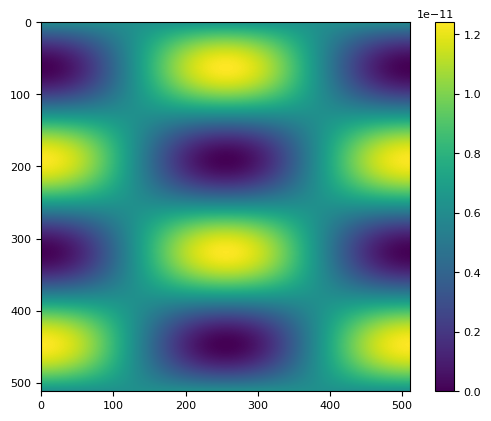

In [140]:
plt.imshow(phi)
plt.colorbar()

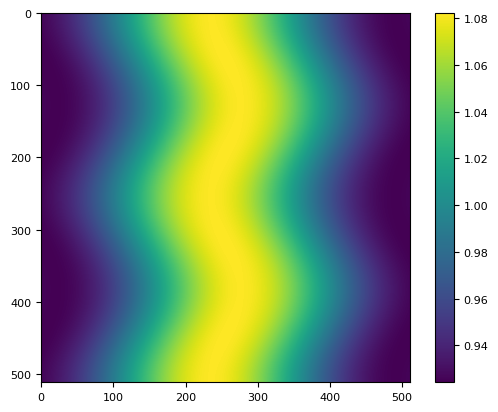

In [141]:
plt.imshow(np.abs(psi)**2)
plt.colorbar()

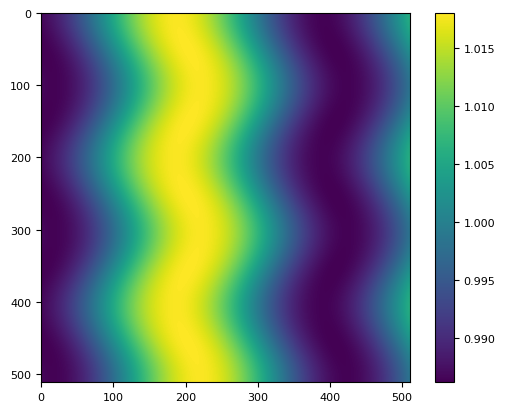

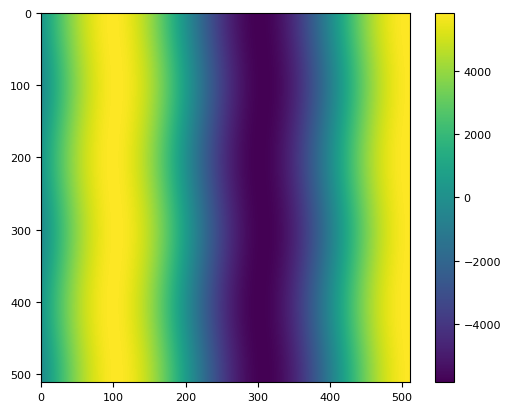

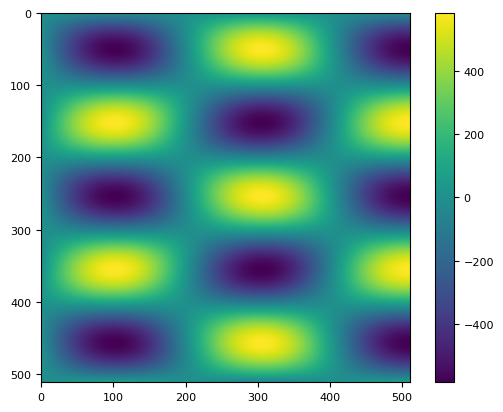

In [54]:
plt.imshow(np.abs(psi)**2)
plt.colorbar()
plt.show()
plt.imshow(vx)
plt.colorbar()
plt.show()
plt.imshow(vy)
plt.colorbar()
plt.show()

In [165]:
import src.wave_schemes as wave_schemes
import src.config as config 
import src.tests as tests 
import src.cosmology as cosmology

N = 128 

def getBaseConfig():
    c = config.generateConfig(dt=1e-4, t0=0)
    c["dt"]                  = 1e-4
    c["domainSize"]          = 1
    c["xlim"]                = [0, 1]
    c["densityYlim"]         = [0, 2]
    c["resolution"]          = 128
    c["timeOrder"]           = 1
    c["dimension"]           = 1
    c["debug"]               = False
    c["slowDown"]            = 1
    c["tEnd"]                = 1
    c["outputTimestep"]      = False
    c["useAdaptiveTimestep"] = True
    c["usePeriodicBC"]       = False
    c["gravity"]             = 0
    c["nThreads"]            = 1
    c["fps"] = 10
    c["dpi"] = 80
    c["plotDebug"] = False
    c["m"] = 1e-23
    c["hbar"] = h_bar
    c["useCosmology"] = True
    c["t0"] = cosmology.getTime(0.01)
    return c


def cosmo2DConfig(c):
    c["dimension"] = 2
    c["usePeriodicBC"] = True
    c["domainSize"] = 1
    c["resolution"] = N
    c["tEnd"] = 1
    c["slowDown"] = 10
    c["plotPhaseMod2"] = False
    c["phaseYlim"] = [-50, 50]
    c["densityYlim"] = [0, 1]
    c["gravity"] = 1.78266192162790e-36
    c["fps"] = 10

c = getBaseConfig()
cosmo2DConfig(c)
scheme = wave_schemes.SpectralScheme(c, tests.periodic2DGaussian)

In [166]:
psi, vx, vy, phi = antisymmetricMode(*scheme.grid, scheme.dx, t0, scheme.kSq, m = 2e-23, hbar = h_bar, L = 10, eps = 0.2, a_c = 0.13, H0 = 100, N = N)

In [163]:
scheme.setPsi(psi)

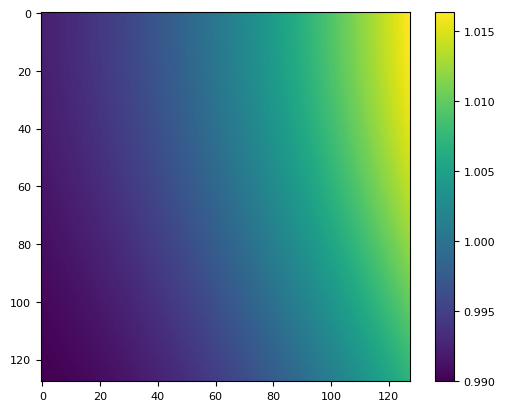

In [164]:
plt.imshow(scheme.getDensity())
plt.colorbar()

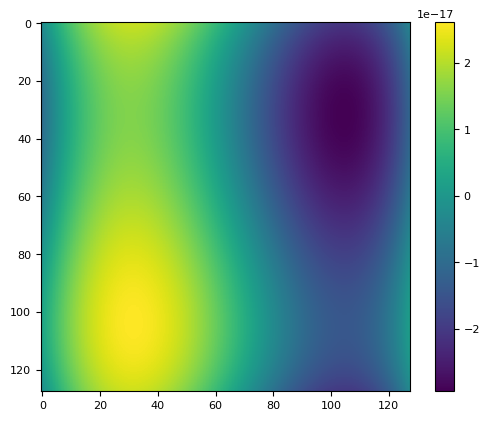

In [159]:
plt.imshow(scheme.potential)
plt.colorbar()

In [135]:
def getPhi(xx, yy, L, eps):
    kp = 2*np.pi / L 
    ka = 4*np.pi / L 
    eps = 0.2 
    return np.cos( ( kp ) * ( xx + eps * kp / ka**2 * np.cos( ka * yy ) ) )


import src.fd_2d as fd

def getRho(xx, yy, L, eps, dx):
    phi = getPhi(xx, yy, L, eps) 
    return fd.getC2Laplacian(phi, dx)

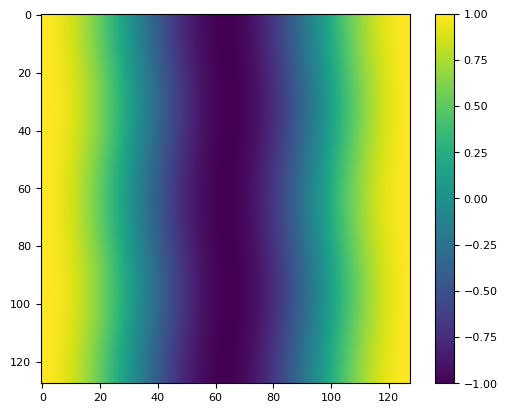

In [147]:
plt.imshow(getPhi(*scheme.grid, scheme.boxWidth, 0.2))
plt.colorbar()

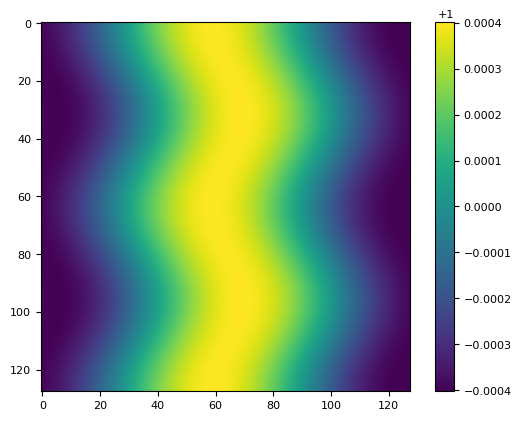

In [137]:
plt.imshow(getRho(*scheme.grid, scheme.boxWidth, 0.2, scheme.dx) * 0.00001 + 1)
plt.colorbar()

In [114]:
scheme.dx

0.0078125

In [116]:
scheme.run(0.00001)

Finished in 0 time steps


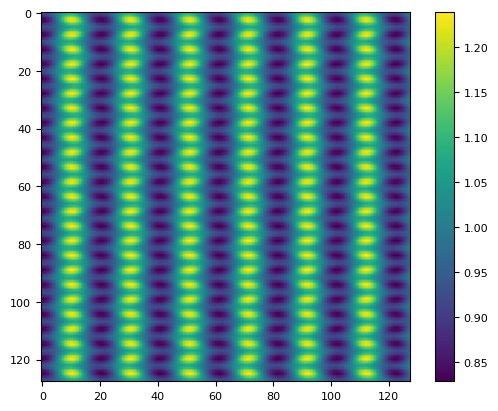

In [118]:
import src.animation as animation

plt.imshow(scheme.getDensity())
plt.colorbar()

t = 0 t_parabolic = 7.84 t_velocity = 700000000.0 t_acceleration = 8000.0 t_gravity = 0.22082011487383776
t = 0.22082011487383776 t_parabolic = 7.84 t_velocity = 0.3825309133006069 t_acceleration = 1.3036772545685513 t_gravity = 0.1709672803959462
t = 0.39178739526978396 t_parabolic = 7.84 t_velocity = 0.1787424380693977 t_acceleration = 0.8691692057953845 t_gravity = 0.10945815217403887
t = 0.5012455474438229 t_parabolic = 7.84 t_velocity = 0.11850490641710804 t_acceleration = 0.6629807040108534 t_gravity = 0.0783942047101575
t = 0.5796397521539803 t_parabolic = 7.84 t_velocity = 0.0891538612243829 t_acceleration = 0.5323959284715557 t_gravity = 0.06138712712720862
t = 0.641026879281189 t_parabolic = 7.84 t_velocity = 0.07152000960333711 t_acceleration = 0.43353832504233014 t_gravity = 0.05073555917191398
t = 0.6917624384531029 t_parabolic = 7.84 t_velocity = 0.05963324698338426 t_acceleration = 0.35393648912398085 t_gravity = 0.043428492911933396
t = 0.7351909313650363 t_parabolic = 

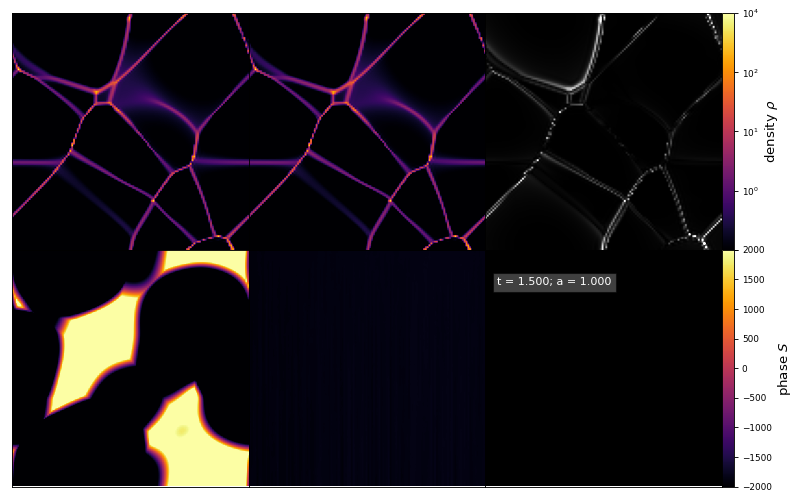

In [48]:

def cosmo1DConfig(c):
    c["dimension"] = 1
    c["usePeriodicBC"] = True
    c["domainSize"] = 512
    c["resolution"] = 128
    c["tEnd"] = 1.2
    c["slowDown"] = 10
    c["plotPhaseMod2"] = False
    c["phaseYlim"] = [-50, 50]
    c["densityYlim"] = [0, 1]
    c["gravity"] = 1
    c["fps"] = 20

def cosmo2DConfig(c):
    c["dimension"] = 2
    c["usePeriodicBC"] = True
    c["domainSize"] = 512
    c["resolution"] = 128
    c["tEnd"] = 0.9
    c["slowDown"] = 10
    c["plotPhaseMod2"] = False
    c["phaseYlim"] = [-50, 50]
    c["densityYlim"] = [0, 1]
    c["gravity"] = 1
    c["fps"] = 20

def cosmo3DConfig(c):
    c["dimension"] = 3
    c["usePeriodicBC"] = True
    c["domainSize"] = 512
    c["resolution"] = 32
    c["tEnd"] = 0.1
    c["slowDown"] = 10
    c["plotPhaseMod2"] = False
    c["phaseYlim"] = [-50, 50]
    c["densityYlim"] = [0, 1]
    c["gravity"] = 1
    c["fps"] = 20

test_list = {
    "standing wave": [tests.standingWave, standingWaveConfig, None],
    "harmonic oscillator convergence": [tests.generate1DUniform, oscillatorConvergenceConfig, lambda x, m: tests.oscillatorPotential1D(x, m, x0 = 0.5)],
    "harmonic oscillator eigenstate": [tests.oscillatorEigenstate1D, oscillatorEigenstateConfig, lambda x, m: tests.oscillatorPotential1D(x, m, x0 = 3)],
    "harmonic oscillator coherent state": [tests.oscillatorCoherentState1D, oscillatorCoherentStateConfig, lambda x, m: tests.oscillatorPotential1D(x, m, x0 = 7)],
    "infinite well": [tests.infiniteWell1D, infiniteWellConfig, None],
    "gaussian wave packet": [lambda x, dx, t, m, hbar: tests.li1(x, dx, t, m, hbar, x0=2), li1Config, None],
    "periodic gaussian wave packet": [lambda x, dx, t, m, hbar: tests.periodicLi1(x, dx, t, m, hbar, x0=2, L = 4), periodicLi1Config, None],
    "gaussian wave packet with background": [lambda x, dx, t, m=1, hbar=1: tests.periodicLi1(x, dx, t, m, hbar, x0=2) + 1, periodicLi1Config, None],
    "hubble expansion": [lambda x, dx, t, m, hbar: tests.li1(x, dx, t, m, hbar, x0=2, eps = 1e-4), li1Config, None],
    "wide hubble expansion": [lambda x, dx, t, m, hbar: tests.li1(x, dx, t, m, hbar, x0=5, eps = 1e-4), hubbleExpansionConfig, None],
    "quasi-shock": [lambda x, dx, t, m, hbar: tests.li2(x, dx, t, m, hbar, x0 = 10), li2Config, None],
    "wave packet collision": [tests.li3, li3Config, None],
    "travelling wave packet": [tests.travellingWavePacket, travellingWavePacketConfig, None],
    "perturbation wave": [tests.cosmological1D, perturbationWaveConfig, None],
    "accuracy test 1D": [lambda xx, dx, t, m = 1, hbar = 1: tests.cosmological1D(xx, dx, t, m, hbar, eps=1e-2, Lx=1, N = 1), accuracyTest1DConfig, None],
    "cosmo 1D": [lambda xx, dx, t, m, hbar: tests.cosmological1D(xx, dx, t, m, hbar, eps=1e-2, Lx=512, N=1), cosmo1DConfig, None],
    "perturbation wave 2D": [lambda x, y, dx, t, m, hbar: tests.cosmological2D(x, y, dx, t, m, hbar, Lx = 1, Ly = 1, N = 1, eps=5e-3), perturbationWave2DConfig, None],
    "cosmo 2D": [lambda x, y, dx, t, m, hbar: tests.cosmological2D(x, y, dx, t, m, hbar, Lx = 512, Ly = 512, N = 4, eps= 1e-2), cosmo2DConfig, None],
    "cosmo 2D test": [lambda x, y, dx, t, m, hbar: tests.cosmological2D(x, y, dx, t, m, hbar, Lx = 25, Ly = 25, N = 5, eps= 5e-3), cosmo2DTestConfig, None],
    "cosmo 2D expansion": [lambda x, y, dx, t, m, hbar: tests.cosmological2D(x, y, dx, t, m, hbar, Lx = 25, Ly = 25, N = 2, eps= 5e-3), cosmo2DExpansionConfig, None],
    "accuracy test 2D": [lambda x, y, dx, t, m, hbar: tests.cosmological2D(x, y, dx, t, m, hbar, Lx = 1, Ly = 1, N = 1, eps= 5e-3), accuracyTest2DConfig, None],
    "stability test 2D": [lambda xx, yy, dx, t, m, hbar: tests.cosmological2D(xx, yy, dx, t, m, hbar, eps=3e-5, Lx=1, Ly=1, N = 10), stabilityTest2DConfig, None],
    "perturbation wave 3D": [lambda x, y, z, dx, t, m, hbar: tests.cosmological3D(x, y, z, dx, t, m, hbar, Lx = 1, Ly = 1, Lz = 1, N = 1, eps=5e-3), perturbationWave3DConfig, None],
    "cosmo 3D": [lambda x, y, z, dx, t, m, hbar: cosmological3D(x, y, z, dx, t, m, hbar, Lx = 512, Ly = 512, Lz = 512, N = 1, eps=1e-2), cosmo3DConfig, None],
    "accuracy test 3D": [lambda x, y, z, dx, t, m, hbar: tests.cosmological3D(x, y, z, dx, t, m, hbar, Lx = 1, Ly = 1, Lz = 1, N = 1, eps=5e-3), accuracyTest3DConfig, None],
}

def ppmConfig(c):
    c["stencilOrder"] = 2
    c["timeOrder"]    = 3
    c["densityLimiter"] = 2
    c["velocityLimiter"] = 2
    c["debug"] = False
    c["phaseYlim"] = [-2000, 2000]
    c["plotDensityLogarithm"] = True
    c["densityYLim"] = [0, 1]
    c["C_parabolic"]  = .49
    c["C_velocity"]   = 3.5
    c["C_potential"] = 400
    c["useAdaptiveYlim"] = False
    c["centralOrder"] = 2
    c["useThirdOrderForward"] = True
    c["limitHJ"] = False
    c["tEnd"] = 1.5

test, testConfig, _ = test_list["cosmo 2D"]
c = getBaseConfig()
testConfig(c)
ppmConfig(c)


solver  = phase_schemes.HOUpwindScheme(c, test) 
#wavesolver  = wave_schemes.SpectralScheme(c, test) 
#for i in range(16):
#    t = 0.1*i
#    solver.run(t)
#    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#    f.suptitle("upwind")
#    im1 = ax1.imshow(solver.fields[0])
#    lap = np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 0)) + np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 1))
#    ax2.imshow(np.log(lap))
#    plt.colorbar(im1)
#    plt.legend()
#    plt.savefig(f"plots/2d/{t}_grad.png")
#    plt.show()
solver.run()
#wavesolver.run()
animation.drawFrame(solver = solver, label = "muscl",    analyticalSolution = test, filename = "muscl",    waveSolver = wavesolver)

#animation.drawFrame(solver = solver, label = "upwind", analyticalSolution = test, filename = "upwind", waveSolver = None)
#

#animation.createAnimation(solver = solver, label = "ppm", analyticalSolution = test, filename = "ppm", waveSolver = wavesolver)

#solver2.run()
#solver3.run()
#wavesolver.run()

#wavesolver.run()
#animation.drawFrame(solver = solver1, label = "upwind", analyticalSolution = test, filename = "upwind", waveSolver = None)
#animation.drawFrame(solver = solver2, label = "muscl",  analyticalSolution = test, filename = "muscl",  waveSolver = wavesolver)
#animation.drawFrame(solver = solver3, label = "ppm",    analyticalSolution = test, filename = "ppm",    waveSolver = wavesolver)

In [33]:
wavesolver.psi = np.sqrt(solver.fields[0]) * np.exp(1j * solver.fields[1])

### Travelling Gaussian Parabolic CFL

0.524288 7.740970225593966e-05
0.5295308799999999 9.163198510327036e-06
0.5348261887999999 1.7118655388357155e-05
0.5401744506879999 2.8938688842511216e-05
0.5455761951948799 4.430542360058071e-05
0.5510319571468287 6.256934999312705e-05
0.556542276718297 7.09918948506231e-06
0.56210769948548 3.5055404846438304e-05
0.5677287764803348 6.476964960776011e-05
0.5734060642451382 1.9835632159560876e-05
0.5791401248875896 5.8523837035184696e-05
0.5849315261364655 1.942706093700415e-05
0.5907808413978302 6.566386543535585e-05
0.5966886498118085 3.446446081797989e-05
0.6026555363099265 8.508003219173676e-05
0.6086820916730258 6.345182670882702e-05
0.6147689125897561 4.221728777080881e-05
0.6209166017156537 2.275958159854398e-05
0.6271257677328101 6.012386951306135e-06
0.6333970254101382 8.051692807474856e-05
0.6397309956642396 7.380787002748374e-05
0.6461283056208821 6.990656128979983e-05
0.6525895886770909 6.910703504637173e-05
0.6591154845638618 7.151784948951198e-05
0.6657066394095005 7.7056

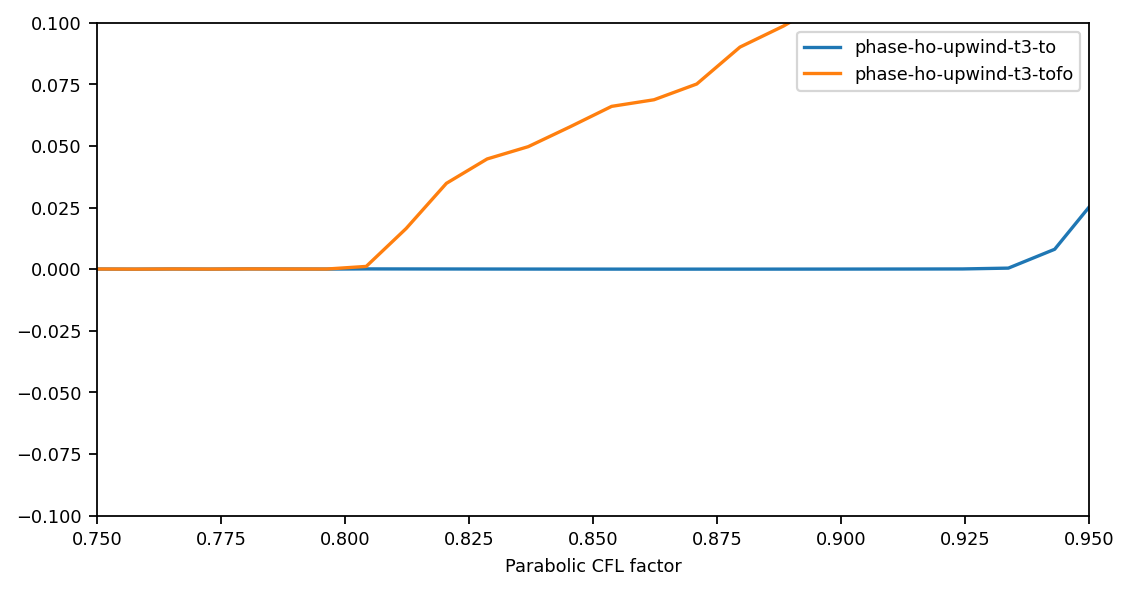

In [ ]:

import matplotlib.pyplot as plt 

plt.figure(figsize=(8,4), dpi=160)
plt.xlabel("Parabolic CFL factor")
plt.ylim([-.1, .1])
plt.xlim([0.75, .95])
ax = plt.subplot(111)


for key in truncations_errors.keys():
    #truncations_errors = np.load(filename)
    dt = np.array(truncations_errors[key]["dt"])
    dx = np.array(truncations_errors[key]["dx"])
    vs = np.array(truncations_errors[key]["v"])
    
    errors = np.array(truncations_errors[key]["errors"])
    xx = dt/(dx**2)
    for i, cfl in enumerate(xx):
        print(cfl, errors[i])
    ax.plot(xx, errors, label=key)

plt.legend()
plt.show()

In [11]:
solver  = phase_schemes.FrommScheme(c, test) 
solver.run()
animation.drawFrame(solver = solver, label = "fromm",    analyticalSolution = test, filename = "fromm",    waveSolver = wavesolver)

t = 0 t_parabolic = 0.00625 t_velocity = 2812500.0 t_acceleration = 1414.213562373095 t_gravity = 1.0655635365407454
t = 0.00625 t_parabolic = 0.00625 t_velocity = 4.021289965143087 t_acceleration = 1.5968538156539025 t_gravity = 1.0655805322132845
t = 0.0125 t_parabolic = 0.00625 t_velocity = 2.010216264274839 t_acceleration = 1.1290387643942457 t_gravity = 1.065130119953246
t = 0.018750000000000003 t_parabolic = 0.00625 t_velocity = 1.3396704403740034 t_acceleration = 0.9217093502849008 t_gravity = 1.0642132995564597
t = 0.025 t_parabolic = 0.00625 t_velocity = 1.0042571519238115 t_acceleration = 0.7980453818682528 t_gravity = 1.0628321004045083
t = 0.03125 t_parabolic = 0.00625 t_velocity = 0.8028971664093328 t_acceleration = 0.7135884484393554 t_gravity = 1.060989573061545
t = 0.0375 t_parabolic = 0.00625 t_velocity = 0.6685640950220062 t_acceleration = 0.6511855675425022 t_gravity = 1.0586897729322695
t = 0.04375 t_parabolic = 0.00625 t_velocity = 0.5725323807365863 t_acceleration

KeyboardInterrupt: 

/tmp/ipykernel_885183/4131337840.py:6: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


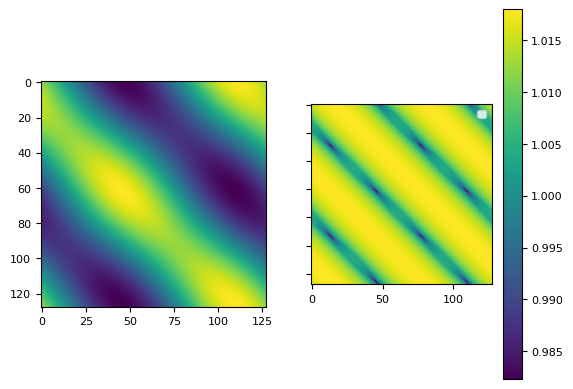

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

im1 = ax1.imshow(solver.fields[0])
lap = np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 0)) + np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 1))
ax2.imshow(np.log(lap))
plt.colorbar(im1)
plt.legend()
plt.show()

In [3]:
import numpy as np

import matplotlib.pyplot as plt 

def loadSlice(file):
    i, j, k, x, y, z, dens, phase, stub = np.loadtxt(file, skiprows = 1, unpack = True)

    N = len(i)
    Dens = np.zeros((128, 128))
    i = (i/512).astype(int)
    j = (j/512).astype(int)
    for l in range(N):
        Dens[i[l], j[l]] = dens[l]
    return np.flip(Dens) 


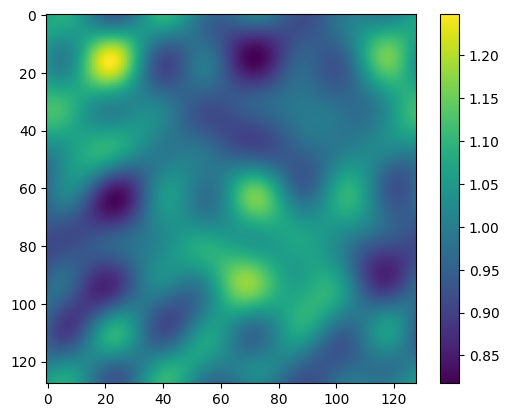

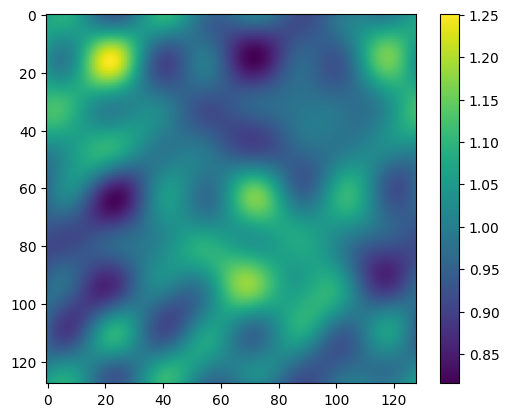

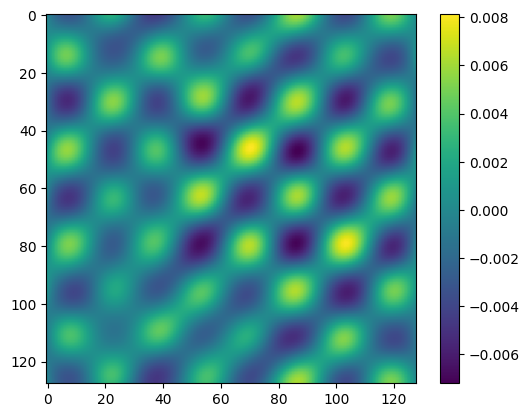

In [8]:
Dens1 = loadSlice("/home/calab912/Documents/gamer-fork/bin/SmallPerturbation/XYslice_z0_wave.100_000009")

plt.imshow(Dens1)
plt.colorbar()
plt.show()

dens2 = loadSlice("/home/calab912/Documents/gamer-fork/bin/SmallPerturbation/XYslice_z0.100_000009")

plt.imshow(dens2)
plt.colorbar()
plt.show()


plt.imshow((Dens1 - dens2)/Dens1)
plt.colorbar()
plt.show()

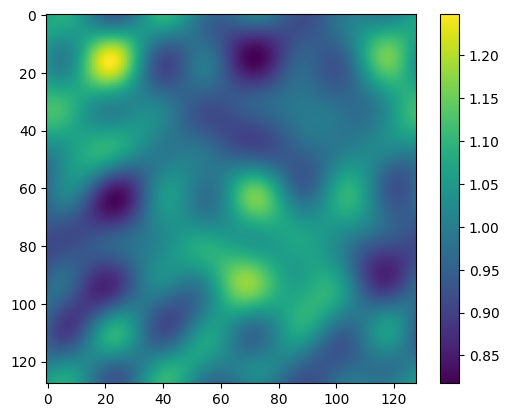

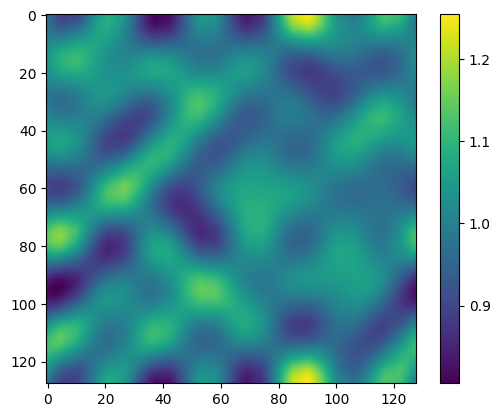

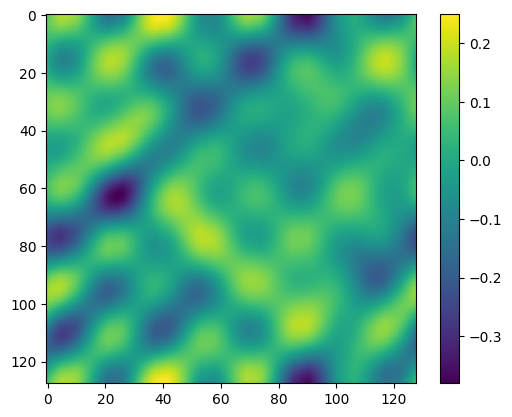

In [10]:
Dens1 = loadSlice("/home/calab912/Documents/gamer-fork/bin/SmallPerturbation/XYslice_z0_wave.100_000009")

plt.imshow(Dens1)
plt.colorbar()
plt.show()

dens2 = loadSlice("/home/calab912/Documents/gamer-fork/bin/SmallPerturbation/XYslice_z0.100_000009")

plt.imshow(dens2)
plt.colorbar()
plt.show()


plt.imshow((Dens1 - dens2)/Dens1)
plt.colorbar()
plt.show()

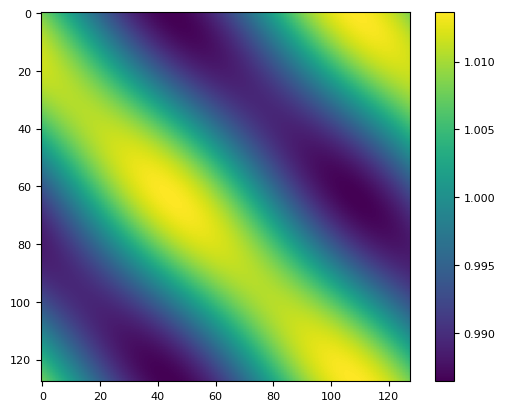

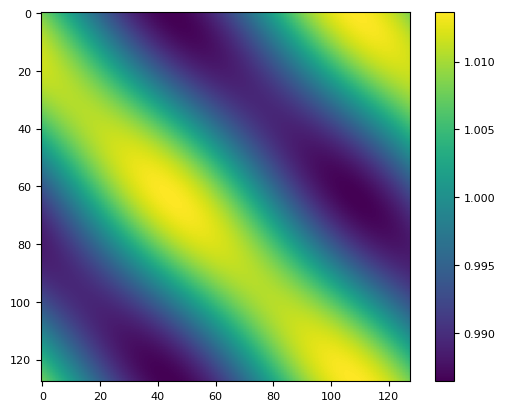

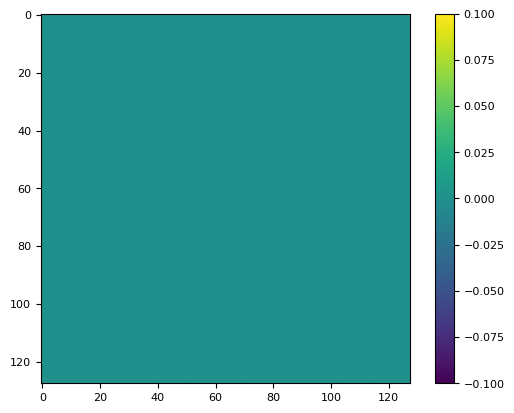

In [20]:
Dens1 = loadSlice("/home/calab912/Documents/gamer-fork/bin/SmallPerturbation/XYslice_z0.100_000001_old")

plt.imshow(Dens1)
plt.colorbar()
plt.show()

dens2 = loadSlice("/home/calab912/Documents/gamer-fork/bin/SmallPerturbation/XYslice_z0.100_000001")

plt.imshow(dens2)
plt.colorbar()
plt.show()


plt.imshow(Dens1 - dens2)
plt.colorbar()
plt.show()

/tmp/ipykernel_53126/1260723724.py:10: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


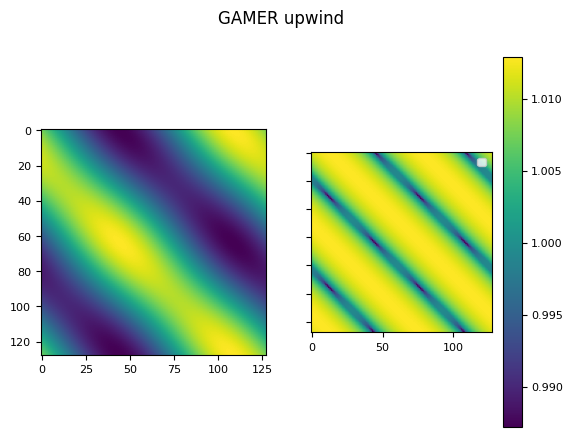

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


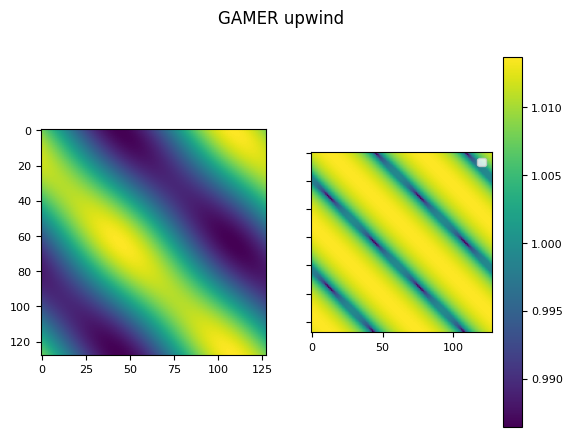

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


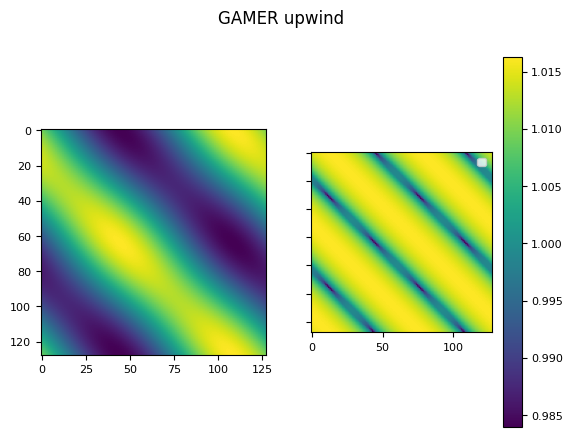

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


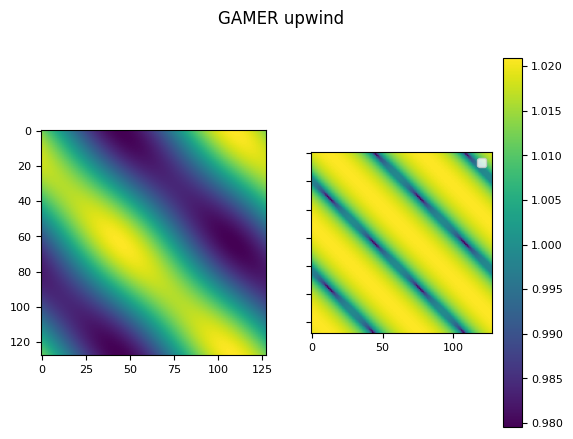

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


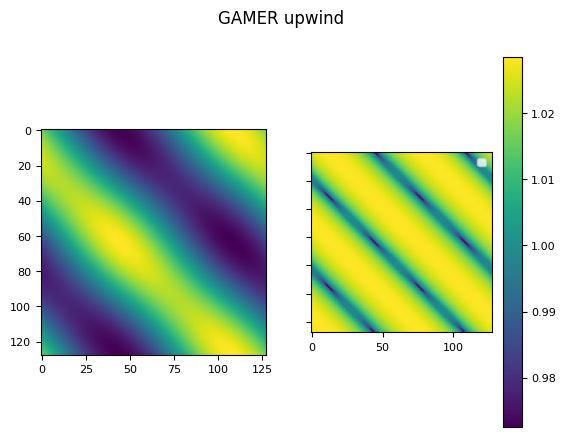

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


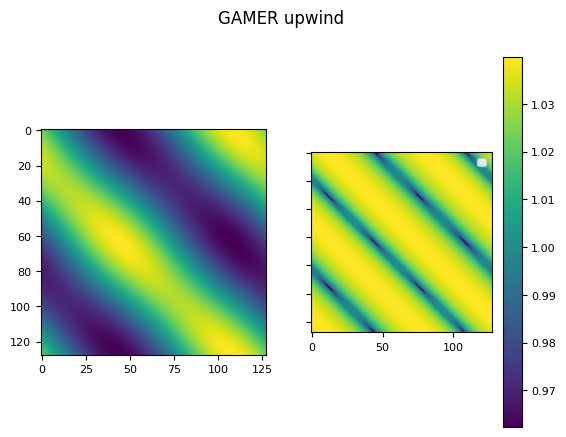

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


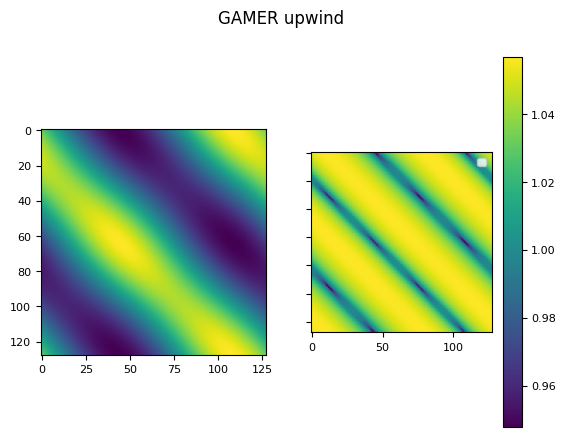

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


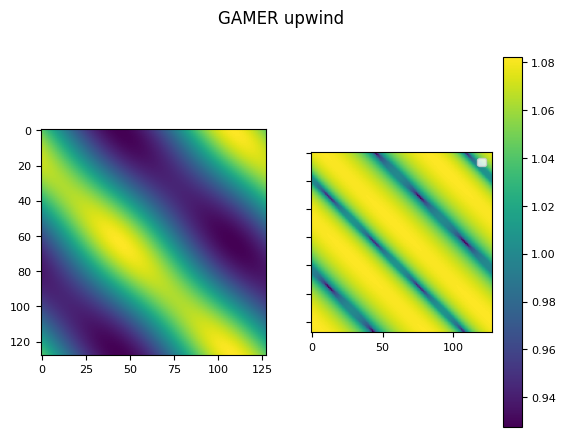

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


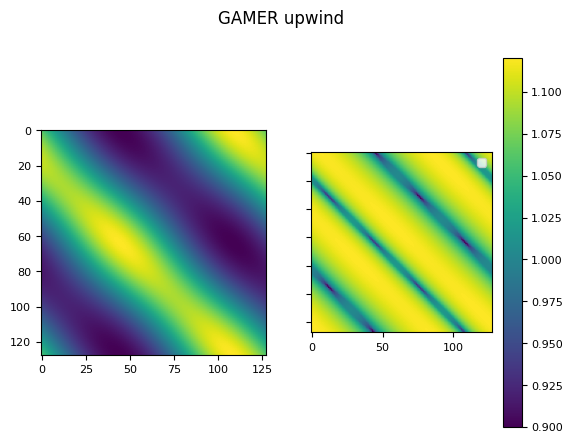

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


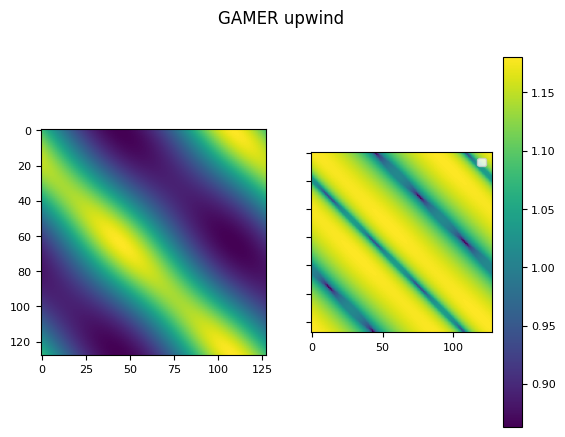

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


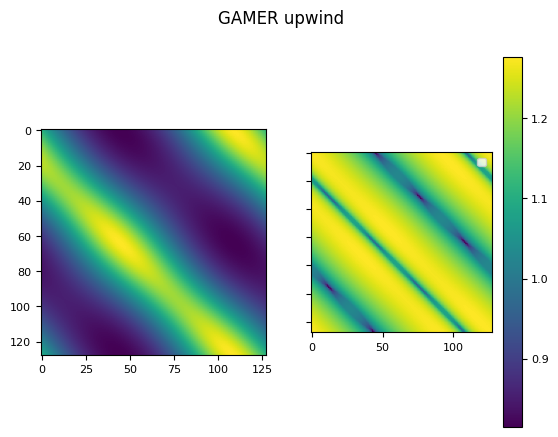

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


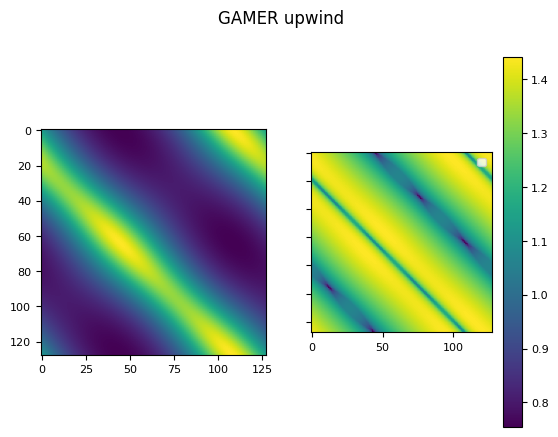

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


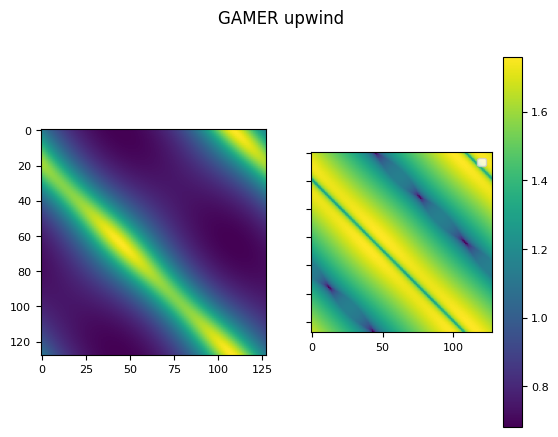

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


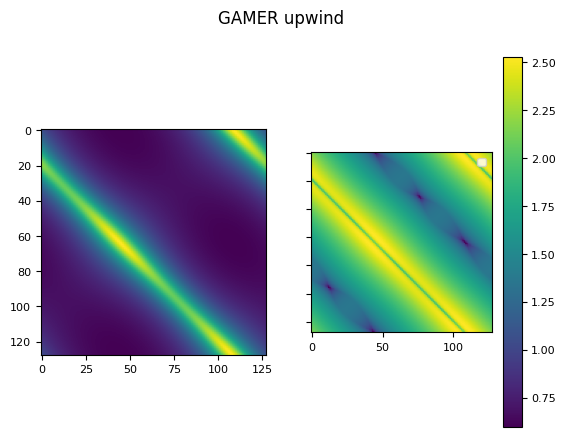

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


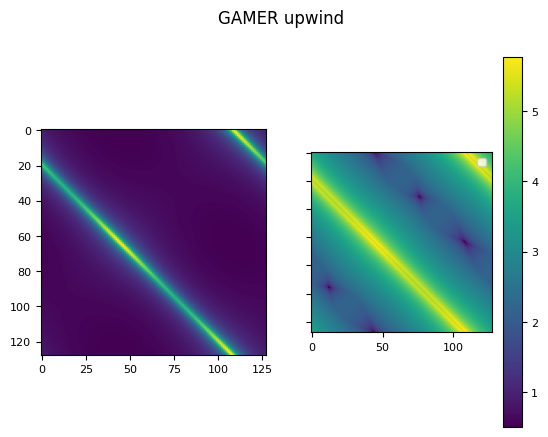

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


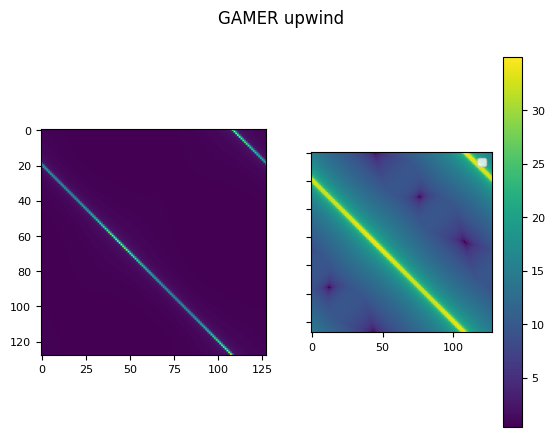

In [55]:

for i in range(16):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.suptitle("GAMER upwind")
    t = i * 0.1

    solver.fields[0] = loadSlice(f"/home/calab912/Documents/gamer-fork/bin/SmallPerturbation/XYslice_z0.100_{i:06}")
    im1 = ax1.imshow(solver.fields[0])
    lap = np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 0)) + np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 1))
    ax2.imshow(np.log(lap))
    plt.colorbar(im1)
    plt.legend()
    plt.savefig(f"plots/2d/GAMER_double_{t}_grad.png")
    plt.show()

In [8]:
np.max(Dens), np.max(solver.fields[0]), np.min(Dens), np.min(solver.fields[0])

(1.012874, 1.011096889149671, 0.9872085, 0.9889643420554388)

In [4]:
solver.grid[0]

array([[  2.,   6.,  10., ..., 502., 506., 510.],
       [  2.,   6.,  10., ..., 502., 506., 510.],
       [  2.,   6.,  10., ..., 502., 506., 510.],
       ...,
       [  2.,   6.,  10., ..., 502., 506., 510.],
       [  2.,   6.,  10., ..., 502., 506., 510.],
       [  2.,   6.,  10., ..., 502., 506., 510.]])

In [ ]:
import src.fd as fd

resolutions = [32, 64, 128]
titles = ["upwind_small_dt", "muscl_small_dt", "d2v2_small_dt", "d0v2_small_dt"]
for r in resolutions:
    solvers = []
    c["resolution"] = r
    c["C_potential"] = 0.01
    c["C_parabolic"] = 0.01

    solvers.append(phase_schemes.UpwindScheme(c, test))
    solvers.append(phase_schemes.HOUpwindScheme(c, test))
    c["densityLimiter"] = 2
    c["velocityLimiter"] = 2
    solvers.append(phase_schemes.PPMScheme(c, test))
    c["densityLimiter"] = 0
    c["velocityLimiter"] = 2
    solvers.append(phase_schemes.PPMScheme(c, test))
    #c["densityLimiter"]  = 2
    #c["velocityLimiter"] = 0
    #solvers.append(phase_schemes.SplitPPMScheme(c, test))
    #c["densityLimiter"]  = 2
    #c["velocityLimiter"] = 0
    #solvers.append(phase_schemes.PPMScheme(c, test))
    #c["densityLimiter"]  = 0
    #c["velocityLimiter"] = 1
    #solvers.append(PPMScheme(c, test))
    #c["densityLimiter"]  = 1
    #c["velocityLimiter"] = 1
    #solvers.append(PPMScheme(c, test))
    #c["densityLimiter"] = 2
    #c["velocityLimiter"] = 1
    #solvers.append(PPMScheme(c, test))
    #c["densityLimiter"] = 1
    #c["velocityLimiter"] = 2
    #solvers.append(PPMScheme(c, test))
    #c["densityLimiter"] = 2
    #c["velocityLimiter"] = 2
    #solvers.append(PPMScheme(c, test))
    #c["densityLimiter"] = 0
    #c["velocityLimiter"] = 2
    #solvers.append(PPMScheme(c, test))
    #c["densityLimiter"] = 2
    #c["velocityLimiter"] = 0
    #solvers.append(PPMScheme(c, test))

    for i, solver in enumerate(solvers):
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        f.suptitle(titles[i])
        t = 0.1
        solver.run(t)
        im1 = ax1.imshow(solver.fields[0])
        lap = np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 0)) + np.abs(fd.getC2Gradient(solver.fields[0], solver.dx, 1))
        ax2.imshow(np.log(lap))
        plt.colorbar(im1)
        plt.legend()
        plt.savefig(f"plots/2d/{titles[i]}_{r}_{t}_grad.png")
        plt.show()


In [ ]:

resolutions = [32, 64, 128]
titles = ["ppm_split"]
times = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

for r in resolutions:
    solvers = []
    c["resolution"] = r
    c["timeOrder"] = 2
    c["stencilOrder"] = 3
    c["velocityLimiter"] = 0 
    c["densityLimiter"] = 2

    solvers.append(phase_schemes.SplitPPMScheme(c, test))

    for i, solver in enumerate(solvers):
        plt.title(titles[i])
        for t in times:
            solver.run(t)
            plt.plot(solver.fields[0], label=f"{t}")
        #f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        #f.suptitle(titles[i])
        #solver.run(t)
        #ax1.imshow(solver.fields[0])
        #lap = fd.getC2Laplacian(solver.fields[0], solver.dx, 0) + fd.getC2Laplacian(solver.fields[0], solver.dx, 1)
        #ax2.imshow(lap)
        #plt.savefig(f"plots/2d/{titles[i]}_{r}.png")
        plt.legend()
        plt.savefig(f"plots/1d/{titles[i]}_{r}.png")
        plt.show()


In [ ]:
times = [0.2,0.4,0.6,0.8,0.9]
resolutions = [32, 64, 128, 256]
titles = ["upwind", "muscl", "d0v0", "d1v0", "d0v1", "d1v1", "d2v1", "d1v2", "d2v2", "d0v2", "d2v0"]

for i in len(titles):
    titles[i] += "_small_dt"

for r in resolutions:
    solvers = []
    c["resolution"] = r

    solvers.append(phase_schemes.UpwindScheme(c, test))
    solvers.append(phase_schemes.HOUpwindScheme(c, test))
    c["densityLimiter"] = 2
    c["velocityLimiter"] = 2
    solvers.append(phase_schemes.PPMScheme(c, test))
    c["densityLimiter"] = 0
    c["velocityLimiter"] = 2
    solvers.append(phase_schemes.PPMScheme(c, test))

    for i, solver in enumerate(solvers):
        plt.title(titles[i])
        for t in times:
            solver.run(t)
            plt.plot(solver.fields[0], label=f"{t}")

        plt.legend()
        plt.savefig(f"plots/1d/ppm_{titles[i]}_{r}.png")
        plt.show()

    #plt.title("muscl")
    #for t in times:
    #    solver2.run(t)
    #    plt.plot(solver2.fields[0], label=f"{t}")
#
    #plt.legend()
    #plt.savefig(f"plots/1d/muscl_{r}.png")
    #plt.show()
#
    #plt.title("ppm")
    #for t in times:
    #    solver3.run(t)
    #    plt.plot(solver3.fields[0], label=f"{t}")
#
    #plt.legend()
    #plt.savefig(f"plots/1d/ppm_{r}.png")
    #plt.show()